# Training Using RobustScalat for Normalization


### Library Import & Initial Setup

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
from math import sqrt, atan2
from scipy.signal import savgol_filter
from hampel import hampel
from sklearn.preprocessing import RobustScaler
from collections import defaultdict


### Load DataSet CIS Raw

In [20]:
# Path ke dataset RX_1
main_folder_path_rx1 = os.path.join('old_dataset', 'dataset RX 1 Lama')

# Inisialisasi struktur data untuk menyimpan hasil
activity_dataframes_rx1 = []
label_list_rx1 = []
label_row_counts_rx1 = defaultdict(int)

# Iterasi melalui setiap subfolder dalam RX_1
for activity_folder in os.listdir(main_folder_path_rx1):
    activity_folder_path = os.path.join(main_folder_path_rx1, activity_folder)
    
    if os.path.isdir(activity_folder_path):  # Pastikan ini folder
        for file_name in os.listdir(activity_folder_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(activity_folder_path, file_name)
                
                # Tambahkan label aktivitas
                label_list_rx1.append(activity_folder)
                
                # Baca file CSV ke DataFrame
                df = pd.read_csv(file_path)
                activity_dataframes_rx1.append(df)

                # Hitung jumlah baris per label
                label_row_counts_rx1[activity_folder] += len(df)

print("Data RX_1 lama telah dimuat.")

Data RX_1 lama telah dimuat.


In [21]:
# Path ke dataset RX_2
main_folder_path_rx2 = os.path.join('old_dataset', 'dataset RX 2 Lama')

# Inisialisasi struktur data untuk menyimpan hasil
activity_dataframes_rx2 = []
label_list_rx2 = []
label_row_counts_rx2 = defaultdict(int)

# Iterasi melalui setiap subfolder dalam RX_2
for activity_folder in os.listdir(main_folder_path_rx2):
    activity_folder_path = os.path.join(main_folder_path_rx2, activity_folder)
    
    if os.path.isdir(activity_folder_path):  # Pastikan ini folder
        for file_name in os.listdir(activity_folder_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(activity_folder_path, file_name)
                
                # Tambahkan label aktivitas
                label_list_rx2.append(activity_folder)
                
                # Baca file CSV ke DataFrame
                df = pd.read_csv(file_path)
                activity_dataframes_rx2.append(df)

                # Hitung jumlah baris per label
                label_row_counts_rx2[activity_folder] += len(df)

print("Data RX_2 lama telah dimuat.")


Data RX_2 lama telah dimuat.


### Membuat fungsi untuk visualisasi

In [7]:
def plot_bar_chart(dd_counts, jl_counts, bd_counts):
    # Labels
    labels = ['dd', 'jl', 'bd']
    
    # Values
    dd_values = [dd_counts.get(str(i), 0) for i in range(3)]
    jl_values = [jl_counts.get(str(i), 0) for i in range(3)]
    bd_values = [bd_counts.get(str(i), 0) for i in range(3)]
    
    x = range(len(dd_values))
    width = 0.2

    fig, ax = plt.subplots()
    ax.bar([i - width for i in x], dd_values, width, label='DD')
    ax.bar(x, jl_values, width, label='JL')
    ax.bar([i + width for i in x], bd_values, width, label='BD')

    ax.set_ylabel('Jumlah Data')
    ax.set_title('Jumlah Data berdasarkan Label')
    ax.set_xticks(x)
    ax.set_xticklabels(['0', '1', '2'])
    ax.legend()

    plt.show()

In [8]:
def plot_data(df, numeric,max_cols):
    """
    Plots the numeric columns of the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame to plot
    numeric (list): List of numeric column names to plot
    """
    # max_cols = 20  # Set maximum columns to plot
    cols_to_plot = numeric[:max_cols]  # Take only the first 10 columns

    plt.figure(figsize=(35, 15))  # Adjusted figure size for better visualization
    for i, col in enumerate(cols_to_plot, 1):
        plt.subplot(len(cols_to_plot), 1, i)
        sns.boxplot(data=df, x=col)
        plt.title(f'Title: {col}')
    plt.tight_layout()
    plt.show()

In [9]:
def plot_boxplots(df,titel):
    """
    Plots boxplots for all numeric columns in the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing numeric data to plot
    """
    plt.figure(figsize=(20, 10))  # Adjust figure size as needed

    all_data = []

    for col in df.columns:
        data = pd.to_numeric(df[col], errors='coerce').dropna().values
        all_data.append(data)

    plt.boxplot(all_data, labels=df.columns)
    plt.xlabel('Subcarier')
    plt.ylabel('Amplitude')
    # plt.title(titel)
    plt.xticks(rotation=45)  # Rotate x-axis labels if necessary for readability

    plt.show()

## Exploratory Data Analysis (EDA)

## total row

### RX1

In [25]:
total_rx1 = 0

# Menampilkan jumlah baris untuk setiap label di RX_1
print("Jumlah Dataset pada RX_1:")
for label, total_rows in label_row_counts_rx1.items():
    print(f'{label} : {total_rows} rows')
    total_rx1 += total_rows

print('Total :', total_rx1)


Jumlah Dataset pada RX_1:
BD : 43342 rows
DD : 38952 rows
JL : 39412 rows
Total : 121706


### RX2

In [26]:
total_rx2 = 0

# Menampilkan jumlah baris untuk setiap label di RX_2
print("Jumlah Dataset pada RX_2:")
for label, total_rows in label_row_counts_rx2.items():
    print(f'{label} : {total_rows} rows')
    total_rx2 += total_rows

print('Total :', total_rx2)


Jumlah Dataset pada RX_2:
BD : 35215 rows
DD : 29619 rows
JL : 30370 rows
Total : 95204


## Statistik Deskriptif

### RX1

In [27]:
activity_dataframes_rx1[0].describe()  # Menampilkan statistik deskriptif dari file pertama RX 1


,rssi,rate,sig_mode,mcs,bandwidth,smoothing,not_sounding,aggregation,stbc,fec_coding,...,ampdu_cnt,channel,secondary_channel,local_timestamp,ant,sig_len,rx_state,real_time_set,real_timestamp,len
count,2989.000000,2989.0,2989.000000,2989.000000,2989.000000,2989.000000,2989.000000,2989.000000,2989.0,2989.0,...,2989.000000,2989.0,2989.0,2.989000e+03,2989.0,2989.000000,2989.0,2989.0,2989.000000,2989.000000
mean,-70.321512,11.0,0.954165,2.895283,0.954165,0.954165,0.954165,0.072265,0.0,0.0,...,0.142188,6.0,1.0,7.465939e+07,0.0,109.955169,0.0,0.0,75.126124,372.266310
std,1.536485,0.0,0.209162,0.865489,0.209162,0.209162,0.209162,0.258969,0.0,0.0,...,0.695311,0.0,0.0,3.618232e+07,0.0,3.738436,0.0,0.0,36.206774,53.545349
min,-74.000000,11.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,6.0,1.0,4.260100e+04,0.0,30.000000,0.0,0.0,0.430911,128.000000
25%,-71.000000,11.0,1.000000,3.000000,1.000000,1.000000,1.000000,0.000000,0.0,0.0,...,0.000000,6.0,1.0,4.378618e+07,0.0,110.000000,0.0,0.0,44.237200,384.000000
50%,-71.000000,11.0,1.000000,3.000000,1.000000,1.000000,1.000000,0.000000,0.0,0.0,...,0.000000,6.0,1.0,7.480674e+07,0.0,110.000000,0.0,0.0,75.194800,384.000000
75%,-70.000000,11.0,1.000000,3.000000,1.000000,1.000000,1.000000,0.000000,0.0,0.0,...,0.000000,6.0,1.0,1.060029e+08,0.0,110.000000,0.0,0.0,106.445000,384.000000
max,-63.000000,11.0,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,...,6.000000,6.0,1.0,1.374255e+08,0.0,239.000000,0.0,0.0,138.003000,384.000000


### RX2

In [28]:
activity_dataframes_rx2[0].describe()  # Menampilkan statistik deskriptif dari file pertama RX 2


,rssi,rate,sig_mode,mcs,bandwidth,smoothing,not_sounding,aggregation,stbc,fec_coding,...,ampdu_cnt,channel,secondary_channel,local_timestamp,ant,sig_len,rx_state,real_time_set,real_timestamp,len
count,2330.000000,2330.0,2330.000000,2330.000000,2330.000000,2330.000000,2330.000000,2330.0,2330.0,2330.0,...,2330.0,2330.0,2330.0,2.330000e+03,2330.0,2330.000000,2330.0,2330.0,2330.000000,2330.000000
mean,-78.929185,11.0,0.778541,0.176824,0.778541,0.778541,0.778541,0.0,0.0,0.0,...,0.0,6.0,1.0,7.508133e+07,0.0,109.942489,0.0,0.0,75.541564,327.306438
std,3.146578,0.0,0.415318,0.381602,0.415318,0.415318,0.415318,0.0,0.0,0.0,...,0.0,0.0,0.0,3.831359e+07,0.0,4.234349,0.0,0.0,38.317512,106.321416
min,-90.000000,11.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,6.0,1.0,4.252700e+04,0.0,30.000000,0.0,0.0,0.451157,128.000000
25%,-81.000000,11.0,1.000000,0.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,...,0.0,6.0,1.0,4.094739e+07,0.0,110.000000,0.0,0.0,41.380500,384.000000
50%,-79.000000,11.0,1.000000,0.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,...,0.0,6.0,1.0,7.572148e+07,0.0,110.000000,0.0,0.0,76.165050,384.000000
75%,-77.000000,11.0,1.000000,0.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,...,0.0,6.0,1.0,1.106791e+08,0.0,110.000000,0.0,0.0,111.157750,384.000000
max,-70.000000,11.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,...,0.0,6.0,1.0,1.385096e+08,0.0,239.000000,0.0,0.0,138.918000,384.000000


## Extract amplitude from dataframes

In [29]:
# Loop melalui setiap dataframe dalam activity_dataframes_rx1
amp_dataframes_rx1 = []
for df_RX1 in activity_dataframes_rx1:
    data_RX1 = []
    for _, row_RX1 in df_RX1.iterrows():
        imaginary_RX1 = []
        real_RX1 = []
        amplitudes_RX1 = []

        csi_data = row_RX1['CSI_DATA']
        # Pastikan CSI_DATA adalah string sebelum diproses
        if isinstance(csi_data, str):
            # Parsing string menjadi daftar integer
            csi_matches = re.findall(r"\[(.*)\]", csi_data)
            if csi_matches:
                csi_string = csi_matches[0]
                csi_raw = [int(x) for x in csi_string.split(" ") if re.match(r"^-?\d+$", x)]



                # Pisahkan angka menjadi imaginary dan real
                for i in range(len(csi_raw)):
                    if i % 2 == 0:
                        imaginary_RX1.append(csi_raw[i])
                    else:
                        real_RX1.append(csi_raw[i])

                # Hitung amplitude
                for i in range(int(len(csi_raw) / 2)):
                    amplitudes_RX1.append(sqrt(imaginary_RX1[i] ** 2 + real_RX1[i] ** 2))
                
                data_RX1.append(amplitudes_RX1)
            else:
                print(f"Tidak ada kecocokan untuk baris: {csi_data}")
        else:
            print(f"Tipe data tidak valid untuk CSI_DATA: {type(csi_data)}")

    # Konversi data ke DataFrame dan tambahkan ke amp_dataframes_rx1
    temp_df_RX1 = pd.DataFrame(data_RX1)
    amp_dataframes_rx1.append(temp_df_RX1)

Tidak ada kecocokan untuk baris: [110 96 6 0 0 0 0 0 0 0 0 0 8 -4 7 -4 8 -3 8 -3 8 -4 8 -3 9 -2 9 -2 8 -3 9 -2 9 -3 9 -1 9 -1 9 -1 9 -2 9 -2 9 -2 9 -2 9 -1 10 -2 10 -2 10 -3 11 -1 11 -2 11 -2 10 -2 0 0 11 -2 11 -2 11 -3 13 -4 12 -2 12 -3 12 -2 13 -3 12 -1 13 -1 13 -3 13 -1 14 -3 13 -3 15 -4 14 -4 15 -4 14 -4 15 -4 14 -5 15 -3 15 -4 17 -4
Tipe data tidak valid untuk CSI_DATA: <class 'float'>
Tipe data tidak valid untuk CSI_DATA: <class 'float'>
Tipe data tidak valid untuk CSI_DATA: <class 'float'>
Tipe data tidak valid untuk CSI_DATA: <class 'float'>
Tidak ada kecocokan untuk baris: [110 96 6 0 0 0 0 0 0 0 0 0 -7 9 -6 10 -8 10 -8 9 -8 9 -8 8 -8 7 -8 8 -9 8 -9 8 -9 8 -9 9 -9 8 -9 8 -8 7 -9 8 -9 7 -9 8 -10 8 -10 7 -9 8 -10 7 -10 7 -9 8 -10 7 -10 8 0 0 -10 8 -10  ESP32
Tidak ada kecocokan untuk baris: [110 ESP32
Tidak ada kecocokan untuk baris: [110 96 6 0 0 0 0 0 0 0 0 0 8 7 6 7 7 8 6 7 7 10 5 8 5 10 4 8 6 10 4 12 4 12 5 12 4 13 3 12 2 10 4 14 3 11 3 12 2 10 2 12 1 11 1 11 0 12 1 12 1 13 

In [30]:
# Loop melalui setiap dataframe dalam activity_dataframes_rx2
amp_dataframes_rx2 = []
for df_RX2 in activity_dataframes_rx2:
    data_RX2 = []
    for _, row in df_RX2.iterrows():
        imaginary_RX2= []
        real_RX2 = []
        amplitudes_RX2 = []

        csi_data = row['CSI_DATA']
        # Pastikan CSI_DATA adalah string sebelum diproses
        if isinstance(csi_data, str):
            # Parsing string menjadi daftar integer
            csi_matches = re.findall(r"\[(.*)\]", csi_data)
            if csi_matches:
                csi_string = csi_matches[0]
                csi_raw = [int(x) for x in csi_string.split(" ") if x != '']

                # Pisahkan angka menjadi imaginary_RX2 dan real_RX2
                for i in range(len(csi_raw)):
                    if i % 2 == 0:
                        imaginary_RX2.append(csi_raw[i])
                    else:
                        real_RX2.append(csi_raw[i])

                # Hitung amplitude
                for i in range(int(len(csi_raw) / 2)):
                    amplitudes_RX2.append(sqrt(imaginary_RX2[i] ** 2 + real_RX2[i] ** 2))
                
                data_RX2.append(amplitudes_RX2)
            else:
                print(f"Tidak ada kecocokan untuk baris: {csi_data}")
        else:
            print(f"Tipe data tidak valid untuk CSI_DATA: {type(csi_data)}")

    # Konversi data ke DataFrame dan tambahkan ke amp_dataframes_rx2
    temp_df_RX2= pd.DataFrame(data_RX2)
    amp_dataframes_rx2.append(temp_df_RX2)

Tipe data tidak valid untuk CSI_DATA: <class 'float'>
Tipe data tidak valid untuk CSI_DATA: <class 'float'>
Tipe data tidak valid untuk CSI_DATA: <class 'float'>
Tipe data tidak valid untuk CSI_DATA: <class 'float'>


In [31]:
columns_to_drop = [0,1,2,3,4,5,32,59,60,61,62,63]

# Iterasi setiap DataFrame dalam list
for i in range(len(amp_dataframes_rx1)):
    amp_dataframes_rx1[i].drop(amp_dataframes_rx1[i].columns[columns_to_drop], axis=1, inplace=True)

# Sama untuk amp_dataframes_rx2 (jika itu juga list of DataFrames)
for i in range(len(amp_dataframes_rx2)):
    amp_dataframes_rx2[i].drop(amp_dataframes_rx2[i].columns[columns_to_drop], axis=1, inplace=True)

## VISUAL EDA

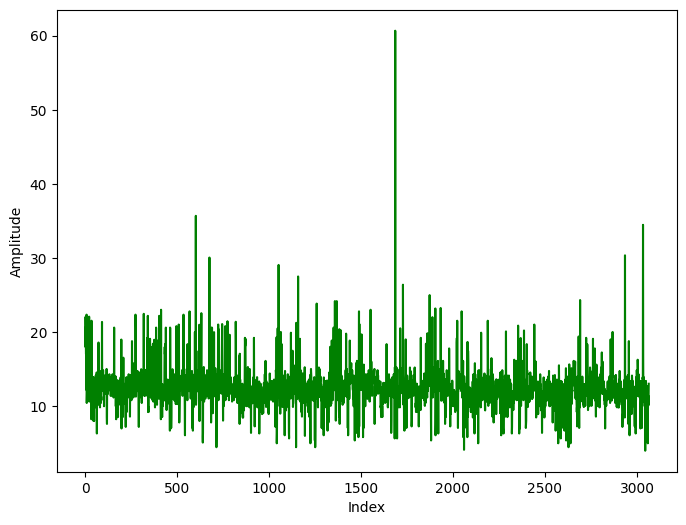

In [32]:
plt.figure(figsize=(8, 6))
plt.plot(amp_dataframes_rx1[10][25],color='g')
plt.xlabel('Index')
plt.ylabel('Amplitude')
# plt.title('Raw CSI Amplitude Data: DD')
plt.show()

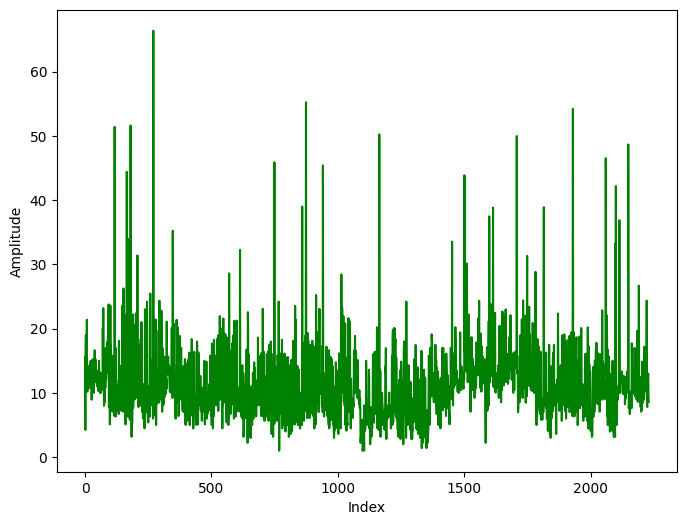

In [33]:
plt.figure(figsize=(8, 6))
plt.plot(amp_dataframes_rx2[10][25],color='g')
plt.xlabel('Index')
plt.ylabel('Amplitude')
# plt.title('Raw CSI Amplitude Data: DD')
plt.show()

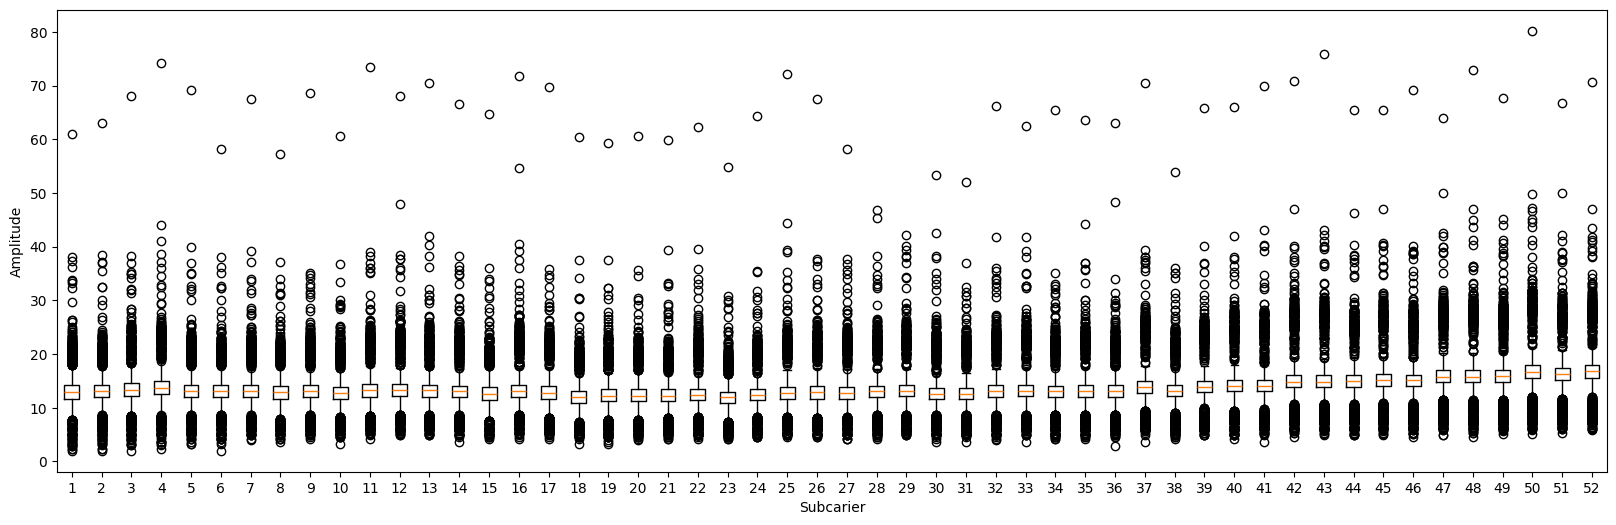

In [34]:
plt.figure(figsize=(20, 6))
plt.boxplot(amp_dataframes_rx1[10])
plt.xlabel('Subcarier')
plt.ylabel('Amplitude')
# plt.title('Boxplot of Before Denoising CSI Amplitude Data')
plt.show()

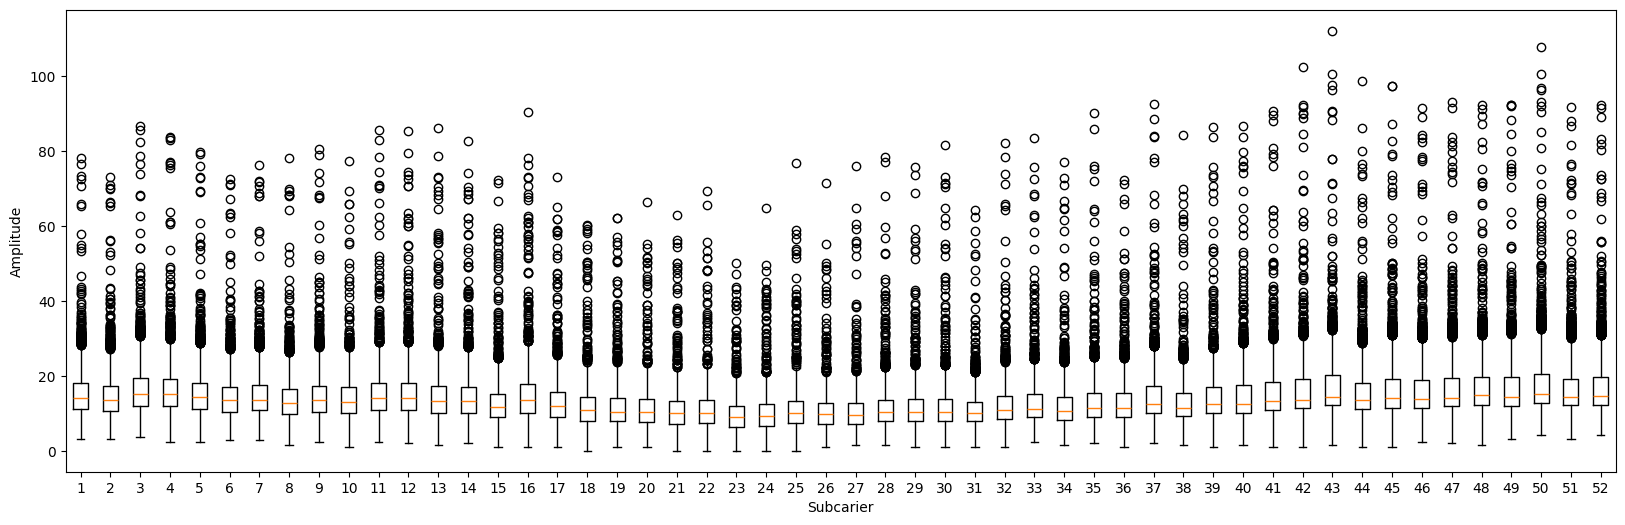

In [35]:
plt.figure(figsize=(20, 6))
plt.boxplot(amp_dataframes_rx2[10])
plt.xlabel('Subcarier')
plt.ylabel('Amplitude')
# plt.title('Boxplot of Before Denoising CSI Amplitude Data')
plt.show()

## Apply noise filter

In [36]:
denoised_dataframes_rx1 = []

for amplitude_RX1 in amp_dataframes_rx1:
    filtered_data_RX1 = pd.DataFrame()
    
    for col_RX1 in amplitude_RX1.columns:
        col_series = amplitude_RX1[col_RX1]
        # Hampel filter
        hampel_filtered = hampel(col_series, window_size=10)
        # Savitzky-Golay filter
        sg_filtered = savgol_filter(hampel_filtered.filtered_data
                                    , window_length=10, polyorder=3)
        filtered_data_RX1[col_RX1] = sg_filtered

    denoised_dataframes_rx1.append(filtered_data_RX1)


In [37]:
denoised_dataframes_rx2 = []

for amplitude_RX2 in amp_dataframes_rx2:
    filtered_data_RX2 = pd.DataFrame()
    
    for col_RX2 in amplitude_RX2.columns:
        col_series = amplitude_RX2[col_RX2]
        # Hampel filter
        hampel_filtered = hampel(col_series, window_size=10)
        # Savitzky-Golay filter
        sg_filtered = savgol_filter(hampel_filtered.filtered_data, window_length=10, polyorder=3)
        filtered_data_RX2[col_RX2] = sg_filtered

    denoised_dataframes_rx2.append(filtered_data_RX2)

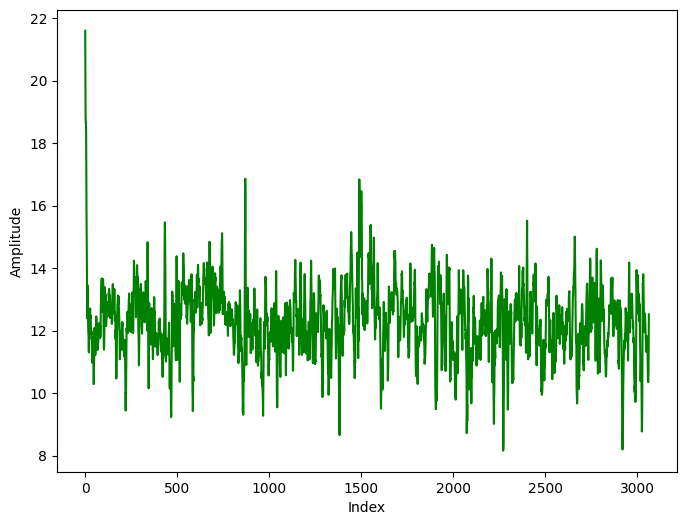

In [38]:
plt.figure(figsize=(8, 6))
plt.plot(denoised_dataframes_rx1[10][25],color='g')
plt.xlabel('Index')
plt.ylabel('Amplitude')
# plt.title('Denoise CSI Amplitude Data: DD')
plt.show()

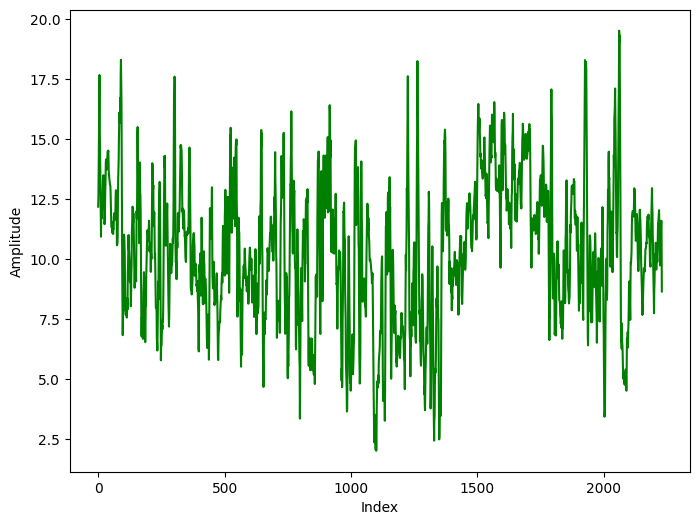

In [39]:
plt.figure(figsize=(8, 6))
plt.plot(denoised_dataframes_rx2[10][25],color='g')
plt.xlabel('Index')
plt.ylabel('Amplitude')
# plt.title('Denoise CSI Amplitude Data: DD')
plt.show()

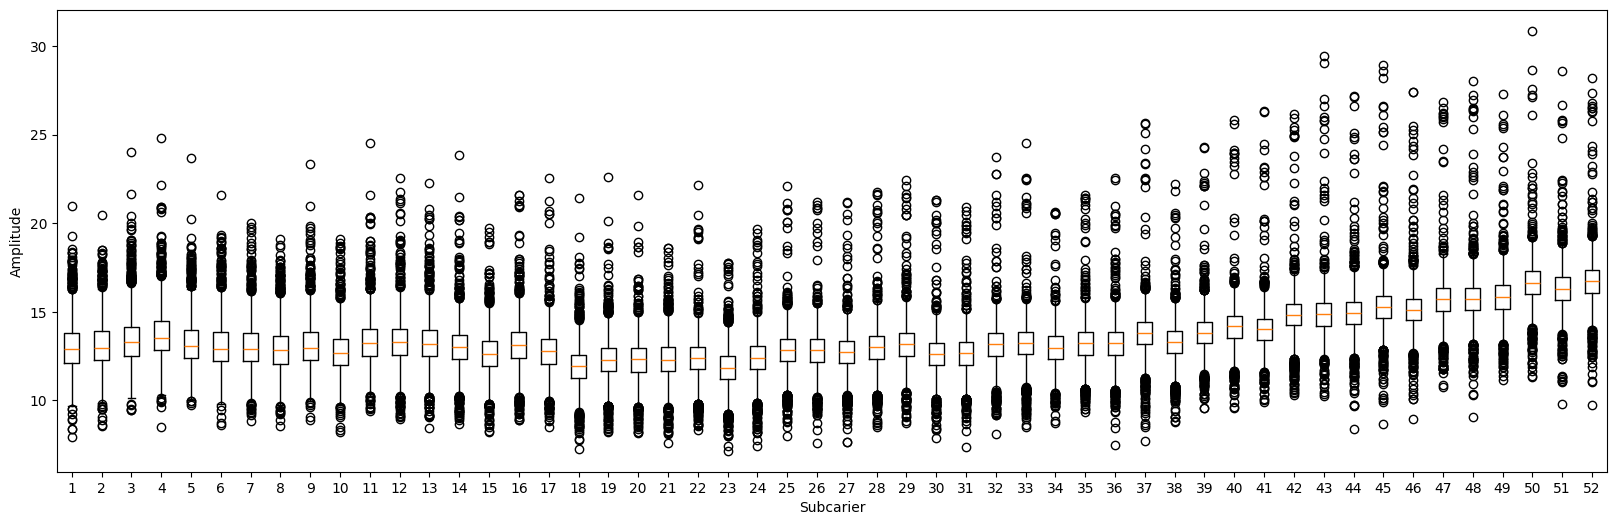

In [40]:
plt.figure(figsize=(20, 6))
plt.boxplot(denoised_dataframes_rx1[10])
plt.xlabel('Subcarier')
plt.ylabel('Amplitude')
# plt.title('Boxplot of Before Denoising CSI Amplitude Data')
plt.show()

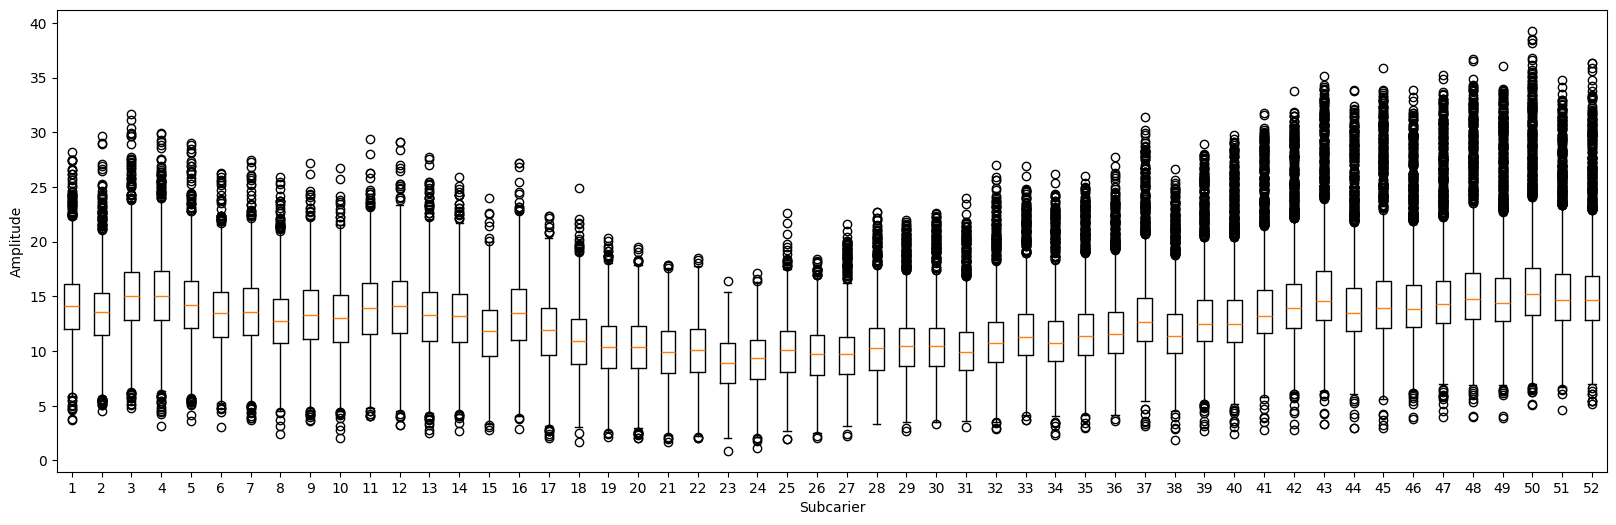

In [41]:
plt.figure(figsize=(20, 6))
plt.boxplot(denoised_dataframes_rx2[10])
plt.xlabel('Subcarier')
plt.ylabel('Amplitude')
# plt.title('Boxplot of Before Denoising CSI Amplitude Data')
plt.show()

In [42]:
denoised_dataframes_rx1[10].describe().to_csv('amp_dataframes_RX1_describe_denois_RX1.csv',index=False)

In [43]:
denoised_dataframes_rx1[10].describe()

,6,7,8,9,10,11,12,13,14,15,...,49,50,51,52,53,54,55,56,57,58
count,3065.000000,3065.000000,3065.000000,3065.000000,3065.000000,3065.000000,3065.000000,3065.000000,3065.000000,3065.000000,...,3065.000000,3065.000000,3065.000000,3065.000000,3065.000000,3065.000000,3065.000000,3065.000000,3065.000000,3065.000000
mean,13.006063,13.129891,13.416877,13.728498,13.213204,13.073825,13.055225,12.912590,13.088449,12.750080,...,14.894262,14.957596,15.295901,15.150670,15.709329,15.733308,15.857758,16.663784,16.336231,16.716806
std,1.322359,1.300102,1.351568,1.382841,1.270802,1.342281,1.280958,1.269404,1.268372,1.223251,...,1.229116,1.201721,1.224436,1.194823,1.186297,1.248057,1.181185,1.196270,1.174668,1.233567
min,7.945252,8.553781,9.449636,8.485244,9.719016,8.631468,8.830670,8.534583,8.907630,8.219871,...,10.268159,8.393117,8.660418,8.928639,10.768706,9.089774,11.129678,11.314062,9.806504,9.722938
25%,12.130678,12.275401,12.519662,12.819105,12.363806,12.194810,12.235191,12.079703,12.288116,11.978634,...,14.223683,14.325614,14.669037,14.516862,15.047203,15.077937,15.176436,16.027830,15.688183,16.040747
50%,12.875055,12.979152,13.266956,13.541011,13.086162,12.918287,12.925029,12.855577,12.982688,12.698730,...,14.874564,14.922097,15.278560,15.126947,15.721231,15.713943,15.830390,16.645720,16.310879,16.711817
75%,13.794901,13.906649,14.167145,14.500986,13.947515,13.857173,13.806244,13.658643,13.848278,13.491013,...,15.492322,15.572389,15.877445,15.740320,16.336275,16.340677,16.492741,17.279125,16.961641,17.342703
max,20.954729,20.470795,24.038908,24.792353,23.675066,21.576153,20.007660,19.120979,23.367611,19.126820,...,29.454374,27.154890,28.934853,27.427624,26.851452,28.029358,27.278997,30.863346,28.582939,28.204218


In [44]:
denoised_dataframes_rx2[10].describe().to_csv('amp_dataframes_RX2_describe_denois_RX2.csv',index=False)

In [45]:
denoised_dataframes_rx2[10].describe()

,6,7,8,9,10,11,12,13,14,15,...,49,50,51,52,53,54,55,56,57,58
count,2231.000000,2231.000000,2231.000000,2231.000000,2231.000000,2231.000000,2231.000000,2231.000000,2231.000000,2231.000000,...,2231.000000,2231.000000,2231.000000,2231.000000,2231.000000,2231.000000,2231.000000,2231.000000,2231.000000,2231.000000
mean,14.159041,13.504648,15.112659,15.112037,14.251418,13.399844,13.637655,12.827181,13.387705,12.956742,...,15.752427,14.467660,15.091653,14.793905,15.272097,15.797558,15.569998,16.358082,15.648213,15.635390
std,3.432756,3.342205,3.745689,3.747370,3.484914,3.317100,3.402688,3.272075,3.355572,3.240834,...,4.904801,4.489874,4.970445,4.478978,4.747816,4.854773,5.005285,5.134043,4.672202,4.698521
min,3.682259,4.551425,4.831350,3.166259,3.612287,3.018951,3.732630,2.462873,3.608176,2.026166,...,3.318734,2.966181,2.994728,3.815894,3.999702,3.996250,3.837876,5.056916,4.635352,5.171144
25%,12.005698,11.461574,12.836292,12.822470,12.123306,11.305701,11.489752,10.695324,11.140368,10.868765,...,12.876289,11.820017,12.102357,12.159050,12.588636,12.930982,12.704834,13.254590,12.841251,12.859252
50%,14.095334,13.609236,15.076252,15.003454,14.209857,13.510266,13.595031,12.732726,13.334201,12.998993,...,14.617566,13.524588,13.937157,13.852697,14.263114,14.774190,14.400876,15.197034,14.666995,14.708708
75%,16.110680,15.302438,17.216236,17.292313,16.387343,15.443054,15.740523,14.803592,15.553990,15.138735,...,17.274643,15.786030,16.420547,16.029332,16.437807,17.164289,16.668612,17.565389,17.032443,16.855061
max,28.228334,29.610540,31.697321,29.955240,29.024057,26.301136,27.440212,25.910995,27.145290,26.742107,...,35.157505,33.887779,35.914886,33.868462,35.237507,36.683636,36.061234,39.277950,34.792919,36.344707


### Save Denoised Amplitudo To Folder RX 1|

In [46]:
# path folder
folder_path_RX1= 'old_datasetfilteredRX1'
print("Reading file:", folder_path_RX1)
# Buat folder jika belum ada
if not os.path.exists(folder_path_RX1):
    os.makedirs(folder_path_RX1)

counter = 1
prev_label = None

for i, dataframe in enumerate(denoised_dataframes_rx1):
    if label_list_rx1[i] != prev_label:
        counter = 1
        prev_label = label_list_rx1[i]
    
    filename = f"{label_list_rx1[i]}-{counter}.csv"
    counter += 1
    
    filepath = os.path.join(folder_path_RX1, filename)
    dataframe.to_csv(filepath, index=False)

Reading file: old_datasetfilteredRX1


### Load Dataset Amplitudo RX1

In [10]:
# Tentukan folder tempat file CSV berada
folder_path_RX1= 'old_datasetfilteredRX1'
print("Reading file:", folder_path_RX1)
# Dapatkan daftar semua file dalam folder tersebut
file_list = [f for f in os.listdir(folder_path_RX1) if f.endswith('.csv')]

# Buat list untuk menyimpan setiap DataFrame
df_list_dd_RX1 = []
df_list_jl_RX1 = []
df_list_bd_RX1 = []



# Baca setiap file CSV, tambahkan kolom label, dan tambahkan ke list yang sesuai
for file_name in file_list:
    file_path = os.path.join(folder_path_RX1, file_name)
    df = pd.read_csv(file_path)
    print("Reading file:", file_path)  # Debugging
    if 'DD' in file_name:
        df['label'] = '0'
        df_list_dd_RX1.append(df)
    elif 'JL' in file_name:
        df['label'] = '1'
        df_list_jl_RX1.append(df)
    elif 'BD' in file_name:
        df['label']='2'
        df_list_bd_RX1.append(df)

# Gabungkan semua DataFrame dengan label '0' menjadi satu DataFrame
dd_df_RX1 = pd.concat(df_list_dd_RX1, ignore_index=True)

# Gabungkan semua DataFrame dengan label '1' menjadi satu DataFrame
jl_df_RX1 = pd.concat(df_list_jl_RX1, ignore_index=True)

# Gabungkan semua DataFrame dengan label '2' menjadi satu DataFrame
bd_df_RX1 = pd.concat(df_list_bd_RX1, ignore_index=True)

print('BD :', len(bd_df_RX1))
print('DD :',len(dd_df_RX1))
print('JL :',len(jl_df_RX1))




Reading file: old_datasetfilteredRX1
Reading file: old_datasetfilteredRX1\BD-1.csv
Reading file: old_datasetfilteredRX1\BD-10.csv
Reading file: old_datasetfilteredRX1\BD-11.csv
Reading file: old_datasetfilteredRX1\BD-12.csv
Reading file: old_datasetfilteredRX1\BD-13.csv
Reading file: old_datasetfilteredRX1\BD-14.csv
Reading file: old_datasetfilteredRX1\BD-15.csv
Reading file: old_datasetfilteredRX1\BD-2.csv
Reading file: old_datasetfilteredRX1\BD-3.csv
Reading file: old_datasetfilteredRX1\BD-4.csv
Reading file: old_datasetfilteredRX1\BD-5.csv
Reading file: old_datasetfilteredRX1\BD-6.csv
Reading file: old_datasetfilteredRX1\BD-7.csv
Reading file: old_datasetfilteredRX1\BD-8.csv
Reading file: old_datasetfilteredRX1\BD-9.csv
Reading file: old_datasetfilteredRX1\DD-1.csv
Reading file: old_datasetfilteredRX1\DD-10.csv
Reading file: old_datasetfilteredRX1\DD-11.csv
Reading file: old_datasetfilteredRX1\DD-12.csv
Reading file: old_datasetfilteredRX1\DD-13.csv
Reading file: old_datasetfiltered

In [11]:
print('BD :', len(bd_df_RX1))
print('DD :',len(dd_df_RX1))
print('JL :',len(jl_df_RX1))

print('Total = ',len(dd_df_RX1)+len(jl_df_RX1)+len(bd_df_RX1))

BD : 43336
DD : 38941
JL : 39409
Total =  121686


### Save Denoised Amplitudo To Folder RX 2

In [49]:
# path folder
folder_path_RX2= 'old_datasetfilteredRX2'
print("Reading file:", folder_path_RX2)
# Buat folder jika belum ada
if not os.path.exists(folder_path_RX2):
    os.makedirs(folder_path_RX2)

counter = 1
prev_label = None

for i, dataframe in enumerate(denoised_dataframes_rx2):
    if label_list_rx2[i] != prev_label:
        counter = 1
        prev_label = label_list_rx2[i]
    
    filename = f"{label_list_rx2[i]}-{counter}.csv"
    counter += 1
    
    filepath = os.path.join(folder_path_RX2, filename)
    dataframe.to_csv(filepath, index=False)


Reading file: old_datasetfilteredRX2


### Load Dataset Amplitudo RX2

In [12]:
# Tentukan folder tempat file CSV berada
folder_path_RX2= 'old_datasetfilteredRX2'
print("Reading file:", folder_path_RX2)
# Dapatkan daftar semua file dalam folder tersebut
file_list = [f for f in os.listdir(folder_path_RX2) if f.endswith('.csv')]

# Buat list untuk menyimpan setiap DataFrame
df_list_dd_RX2 = []
df_list_jl_RX2 = []
df_list_bd_RX2 = []



# Baca setiap file CSV, tambahkan kolom label, dan tambahkan ke list yang sesuai
for file_name in file_list:
    file_path = os.path.join(folder_path_RX2, file_name)
    df = pd.read_csv(file_path)
    print("Reading file:", file_path)  # Debugging
    if 'DD' in file_name:
        df['label'] = '0'
        df_list_dd_RX2.append(df)
    elif 'JL' in file_name:
        df['label'] = '1'
        df_list_jl_RX2.append(df)
    elif 'BD' in file_name:
        df['label']='2'
        df_list_bd_RX2.append(df)

# Gabungkan semua DataFrame dengan label '0' menjadi satu DataFrame
dd_df_RX2 = pd.concat(df_list_dd_RX2, ignore_index=True)

# Gabungkan semua DataFrame dengan label '1' menjadi satu DataFrame
jl_df_RX2 = pd.concat(df_list_jl_RX2, ignore_index=True)

# Gabungkan semua DataFrame dengan label '2' menjadi satu DataFrame
bd_df_RX2 = pd.concat(df_list_bd_RX2, ignore_index=True)

print('BD :', len(bd_df_RX2))
print('DD :',len(dd_df_RX2))
print('JL :',len(jl_df_RX2))


Reading file: old_datasetfilteredRX2
Reading file: old_datasetfilteredRX2\BD-1.csv
Reading file: old_datasetfilteredRX2\BD-10.csv
Reading file: old_datasetfilteredRX2\BD-11.csv
Reading file: old_datasetfilteredRX2\BD-12.csv
Reading file: old_datasetfilteredRX2\BD-13.csv
Reading file: old_datasetfilteredRX2\BD-14.csv
Reading file: old_datasetfilteredRX2\BD-15.csv
Reading file: old_datasetfilteredRX2\BD-2.csv
Reading file: old_datasetfilteredRX2\BD-3.csv
Reading file: old_datasetfilteredRX2\BD-4.csv
Reading file: old_datasetfilteredRX2\BD-5.csv
Reading file: old_datasetfilteredRX2\BD-6.csv
Reading file: old_datasetfilteredRX2\BD-7.csv
Reading file: old_datasetfilteredRX2\BD-8.csv
Reading file: old_datasetfilteredRX2\BD-9.csv
Reading file: old_datasetfilteredRX2\DD-1.csv
Reading file: old_datasetfilteredRX2\DD-10.csv
Reading file: old_datasetfilteredRX2\DD-11.csv
Reading file: old_datasetfilteredRX2\DD-12.csv
Reading file: old_datasetfilteredRX2\DD-13.csv
Reading file: old_datasetfiltered

In [4]:
print('BD :', len(bd_df_RX2))
print('DD :',len(dd_df_RX2))
print('JL :',len(jl_df_RX2))

print('Total = ',len(dd_df_RX2)+len(jl_df_RX2)+len(bd_df_RX2))

BD : 35211
DD : 29619
JL : 30370
Total =  95200


In [13]:
import matplotlib.pyplot as plt

# Hitung jumlah baris untuk setiap label dalam DataFrame dd_df
dd_counts = dd_df_RX1['label'].value_counts()
dd_counts_RX2 = dd_df_RX2['label'].value_counts()
# Hitung jumlah baris untuk setiap label dalam DataFrame jl_df
jl_counts = jl_df_RX1['label'].value_counts()
jl_counts_RX2 = jl_df_RX2['label'].value_counts()
# Hitung jumlah baris untuk setiap label dalam DataFrame bd_df
bd_counts = bd_df_RX1['label'].value_counts()
bd_counts_RX2 = bd_df_RX2['label'].value_counts()

# Gabungkan count RX1 dan RX2
dd_counts_total = dd_counts.add(dd_counts_RX2, fill_value=0)
jl_counts_total = jl_counts.add(jl_counts_RX2, fill_value=0)
bd_counts_total = bd_counts.add(bd_counts_RX2, fill_value=0)





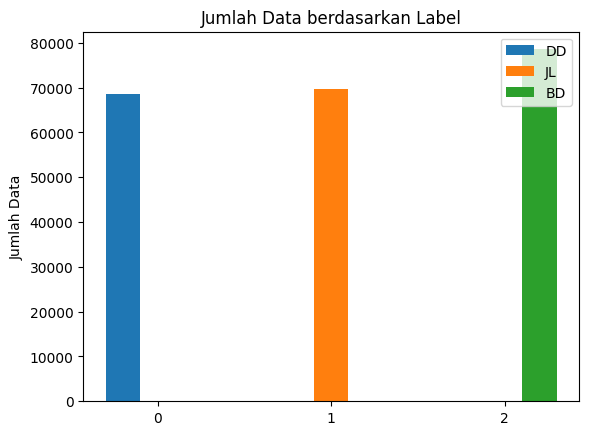

In [14]:
plot_bar_chart(dd_counts_total, jl_counts_total, bd_counts_total)

In [15]:
# Function to identify outliers using IQR
def iqr_outliers(df):
    numeric_df = df.select_dtypes(include=[np.number])
    Q1 = numeric_df.quantile(0.25)
    Q3 = numeric_df.quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[((numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))).any(axis=1)]
    return outliers, numeric_df.columns

In [16]:
dd_df_total = pd.concat([dd_df_RX1, dd_df_RX2], ignore_index=True)

# Panggil fungsi outlier detection
outliers_dd, numeric_cols_dd = iqr_outliers(dd_df_total)

# Print hasilnya
print("Outliers  duduk:")
outliers_dd

Outliers  duduk:


,6,7,8,9,10,11,12,13,14,15,...,50,51,52,53,54,55,56,57,58,label
0,7.195219,7.185499,6.237174,3.759373,3.070044,2.268661,4.643239,3.150698,5.598734,6.319253,...,30.299500,31.805544,31.438540,32.015760,33.960080,32.009853,32.738743,33.709984,33.105660,0
1,5.482887,4.582400,4.777839,4.158640,3.644160,4.318009,5.481376,4.500600,5.262649,6.127815,...,22.310629,23.573750,23.181637,24.505693,24.193020,24.568203,24.496304,24.913400,23.777819,0
2,4.225416,2.914152,3.625549,4.048348,3.987832,5.380418,5.811321,5.457382,5.629588,6.608619,...,20.151423,21.298370,20.729965,22.400457,21.157179,22.615608,22.399399,22.067734,20.728794,0
3,3.341881,1.975718,2.759616,3.599907,4.134253,5.671833,5.743350,6.048007,6.411353,7.479212,...,21.994112,23.113718,22.302357,24.012798,22.794890,24.396418,24.508682,23.351679,22.061940,0
4,2.751359,1.562058,2.159352,2.984725,4.116619,5.408195,5.387738,6.299439,7.319746,8.457139,...,26.010923,27.154102,26.117636,27.655466,27.048485,28.154982,28.884804,26.943930,25.880606,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68309,16.797297,16.618689,16.633677,19.184965,16.785566,16.510695,16.667719,16.144508,16.033592,15.878319,...,21.696314,19.648157,19.874886,20.413694,20.224281,18.677368,20.475145,20.716063,19.947464,0
68310,16.563957,16.241552,16.387842,18.832163,16.136625,16.263226,16.385563,15.834299,15.747394,15.193648,...,21.387012,19.477005,19.532827,19.987340,19.947521,18.323889,20.424398,20.355438,19.755575,0
68336,16.115162,16.321537,16.846910,17.460928,15.771519,15.653168,15.584367,15.334239,16.589895,15.870204,...,19.974417,20.787535,19.818450,20.332935,20.503138,20.017542,21.696308,20.848965,20.623796,0
68337,16.392540,16.774235,17.072065,17.673195,16.131054,16.142720,15.870855,15.707643,16.700031,16.012342,...,20.216766,20.955393,20.071835,20.507286,20.607760,20.066063,21.817732,21.050000,20.673460,0


In [17]:
jl_df_total = pd.concat([jl_df_RX1, jl_df_RX2], ignore_index=True)

# Panggil fungsi outlier detection
outliers_jl, numeric_cols_jl = iqr_outliers(jl_df_total)

# Print hasilnya
print("Outliers  jalan:")
outliers_jl

Outliers  jalan:


,6,7,8,9,10,11,12,13,14,15,...,50,51,52,53,54,55,56,57,58,label
0,14.193143,18.196283,18.922695,21.215916,17.870540,19.097797,17.386677,22.062922,20.570173,20.657007,...,17.762508,15.035228,15.033743,14.105640,13.876165,14.353010,11.616164,11.144075,9.976420,1
2,4.846096,7.691440,4.514241,4.781570,7.515361,6.074456,5.680073,5.570501,6.310631,6.156850,...,6.652531,9.783082,6.182868,7.142598,5.825431,4.803629,4.645798,4.352638,3.556663,1
3,6.460479,8.218203,5.570633,5.125483,8.751777,7.076409,7.356659,6.418000,7.492402,7.391631,...,6.402567,8.870293,6.159824,6.381565,5.865468,4.729626,4.964924,4.090426,3.858738,1
5,15.934751,14.728137,15.893757,15.304030,16.478434,17.294790,17.780315,16.843730,17.778920,17.199554,...,11.663670,14.054588,15.036971,12.104429,14.234857,9.764611,13.797080,10.864808,11.637382,1
6,18.200506,16.108265,19.664316,19.645967,18.428608,19.874075,20.612787,19.382046,20.366430,19.939203,...,12.568780,16.223650,17.799435,14.650247,17.000319,10.438695,16.395681,13.657361,14.620454,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64581,18.945870,18.890951,20.042700,20.618864,20.699223,21.287413,20.863626,21.830875,21.741460,21.518835,...,22.160019,23.527740,21.903473,22.722937,22.869772,21.613583,23.567556,21.526217,21.839901,1
64582,17.473137,17.377974,18.472673,18.891140,18.935610,19.395603,19.027962,19.669771,19.640478,19.687551,...,20.682352,21.743637,20.464417,21.150070,20.991447,20.109745,21.860628,20.076683,20.247746,1
66863,24.864935,24.282381,25.830680,27.245045,25.932090,25.558004,26.452068,26.762514,26.841960,27.557210,...,23.696290,26.488714,23.528364,26.342490,26.183420,25.025717,28.217493,26.559832,25.594280,1
66864,22.686504,22.538055,27.002703,25.736185,25.990177,24.633396,26.323841,24.166828,25.788935,25.507576,...,21.252169,23.379774,21.221523,22.909780,22.992891,23.099072,24.315440,22.722834,22.742174,1


In [18]:
bd_df_total = pd.concat([bd_df_RX1, bd_df_RX2], ignore_index=True)

# Panggil fungsi outlier detection
outliers_bd, numeric_cols_bd = iqr_outliers(bd_df_total)

# Print hasilnya
print("Outliers  berdiri:")
outliers_bd

Outliers  berdiri:


,6,7,8,9,10,11,12,13,14,15,...,50,51,52,53,54,55,56,57,58,label
0,23.960388,24.918170,27.913101,24.156616,25.966795,26.192448,26.660540,20.644201,22.331028,19.929560,...,28.541687,29.670761,25.642689,28.097336,27.124346,28.951984,29.304546,28.066162,27.849540,2
1,19.663970,19.995943,22.250338,20.916512,20.727940,20.692867,21.285185,18.700730,19.508167,17.888960,...,23.865065,25.509502,23.208263,24.434628,24.426327,24.403011,25.947365,24.320934,25.414492,2
2,17.848646,17.866943,19.812166,19.990997,18.418280,18.225120,18.814892,18.257792,18.669940,17.582525,...,21.855620,23.786644,22.467384,23.138075,23.737228,22.520603,24.867214,23.080498,24.667257,2
3,17.765661,17.698795,19.636925,20.589067,18.182480,17.895552,18.416376,18.766161,19.146048,18.379168,...,21.693426,23.713772,22.813314,23.420828,24.337458,22.472850,25.276457,23.523668,24.993500,2
4,18.666262,18.659126,20.762959,21.919716,19.165210,18.810505,19.256351,19.676603,20.266191,19.647793,...,22.558554,24.502472,23.639310,24.496042,25.507410,23.427835,26.387450,24.829262,25.778875,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78542,18.572180,15.057531,16.009241,15.919346,17.080300,14.474192,12.897284,12.545296,12.641747,13.428069,...,22.494535,20.478981,21.596981,21.703240,21.856840,22.796501,24.325583,24.837439,23.827114,2
78543,21.076975,15.491415,16.091380,16.005789,17.676472,14.466682,12.807472,12.301719,12.929488,13.938886,...,25.946650,22.930502,24.940262,25.388939,24.707325,25.913109,27.761065,28.717627,28.533876,2
78544,21.727398,15.558088,15.552510,15.837364,17.406815,14.068499,12.623364,11.815687,13.019669,13.785069,...,26.329086,23.148415,25.658955,26.233084,24.775936,26.521816,28.282934,29.418657,30.149137,2
78545,19.400599,14.969675,14.130280,15.227901,15.884510,13.130031,12.246156,11.003204,12.748290,12.583282,...,21.933710,19.952194,22.220427,22.581013,20.568865,23.366562,24.186950,25.240808,26.699150,2


C:\Users\Hp\AppData\Local\Temp\ipykernel_17240\2851536282.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_data, labels=df.columns)


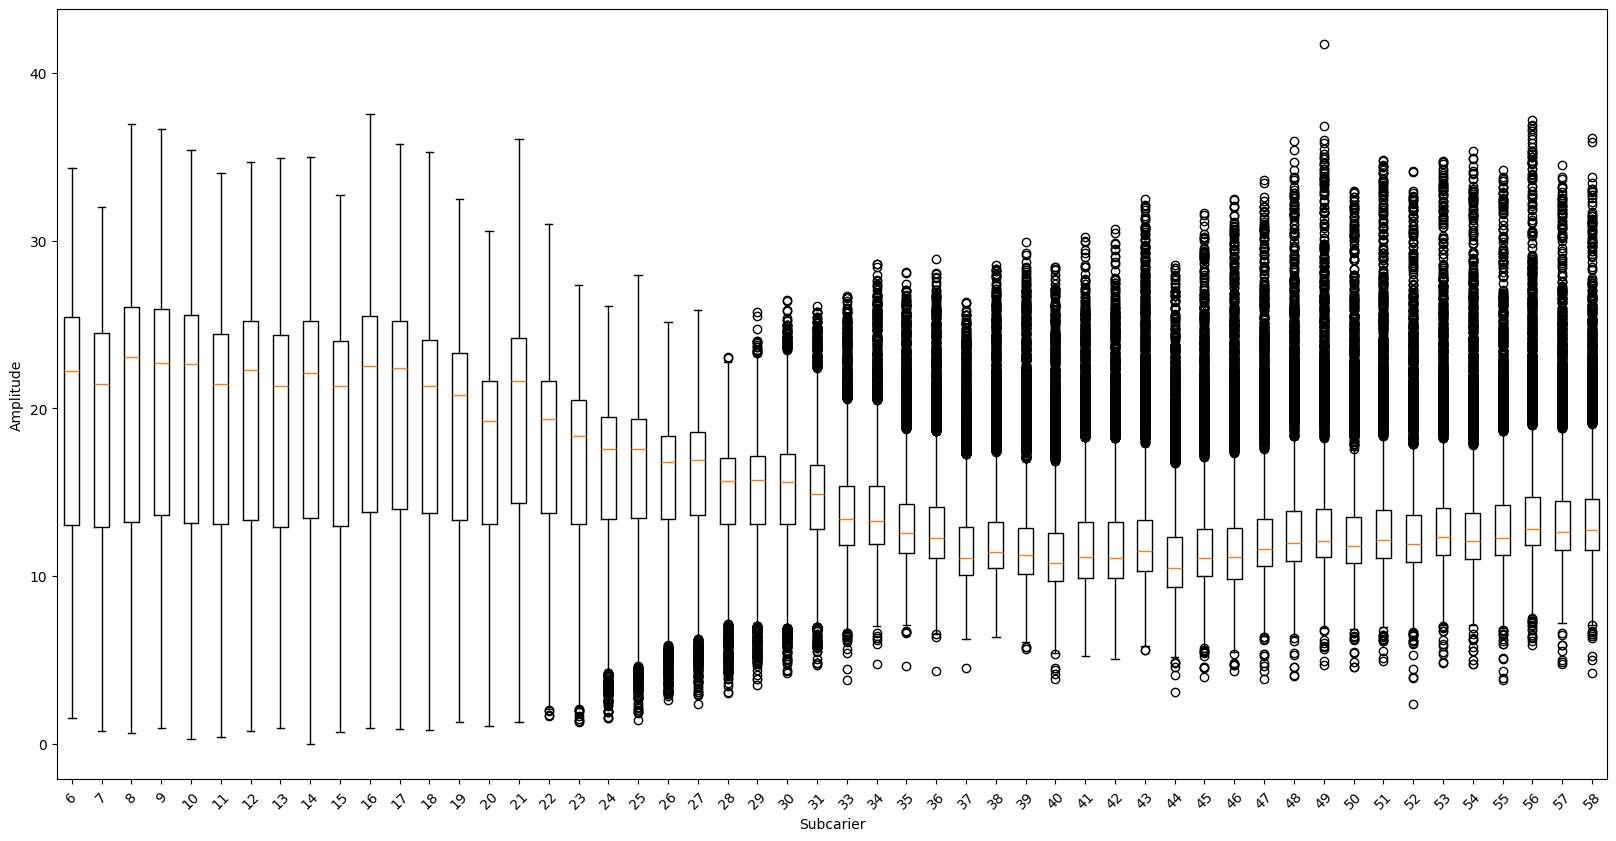

In [19]:
outliers_iqr_dd_without_label = outliers_dd.drop(columns=['label'])
plot_boxplots(outliers_iqr_dd_without_label,'Boxplot Before Normalization Amplituo Data')

In [20]:
cleaned_jl_df = jl_df_total.drop(outliers_jl.index)
cleaned_bd_df = bd_df_total.drop(outliers_bd.index)
cleaned_dd_df = dd_df_total.drop(outliers_dd.index)

# Apply RobustScaler
scaler = RobustScaler()
scaled_jl_data = scaler.fit_transform(cleaned_jl_df[numeric_cols_jl])
scaled_bd_data = scaler.fit_transform(cleaned_bd_df[numeric_cols_bd])
scaled_dd_data = scaler.fit_transform(cleaned_dd_df[numeric_cols_dd])

# Convert the scaled data back to a DataFrame
scaled_jl_df = pd.DataFrame(scaled_jl_data, columns=numeric_cols_jl, index=cleaned_jl_df.index)
scaled_bd_df = pd.DataFrame(scaled_bd_data, columns=numeric_cols_bd, index=cleaned_bd_df.index)
scaled_dd_df = pd.DataFrame(scaled_dd_data, columns=numeric_cols_dd, index=cleaned_dd_df.index)

# If you want to combine the scaled numeric columns back with the non-numeric columns:
final_jl_df = pd.concat([scaled_jl_df, cleaned_jl_df.drop(columns=numeric_cols_jl)], axis=1)
final_bd_df = pd.concat([scaled_bd_df, cleaned_bd_df.drop(columns=numeric_cols_bd)], axis=1)
final_dd_df = pd.concat([scaled_dd_df, cleaned_dd_df.drop(columns=numeric_cols_dd)], axis=1)



In [21]:
# Apply RobustScaler
scaler = RobustScaler()
scaled_jl_data = scaler.fit_transform(cleaned_jl_df[numeric_cols_jl])
scaled_bd_data = scaler.fit_transform(cleaned_bd_df[numeric_cols_bd])
scaled_dd_data = scaler.fit_transform(cleaned_dd_df[numeric_cols_dd])

# Convert the scaled data back to a DataFrame
scaled_jl_df = pd.DataFrame(scaled_jl_data, columns=numeric_cols_jl, index=cleaned_jl_df.index)
scaled_bd_df = pd.DataFrame(scaled_bd_data, columns=numeric_cols_bd, index=cleaned_bd_df.index)
scaled_dd_df = pd.DataFrame(scaled_dd_data, columns=numeric_cols_dd, index=cleaned_dd_df.index)

# If you want to combine the scaled numeric columns back with the non-numeric columns:
final_jl_df = pd.concat([scaled_jl_df, cleaned_jl_df.drop(columns=numeric_cols_jl)], axis=1)
final_bd_df = pd.concat([scaled_bd_df, cleaned_bd_df.drop(columns=numeric_cols_bd)], axis=1)
final_dd_df = pd.concat([scaled_dd_df, cleaned_dd_df.drop(columns=numeric_cols_dd)], axis=1)

C:\Users\Hp\AppData\Local\Temp\ipykernel_17240\2851536282.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_data, labels=df.columns)


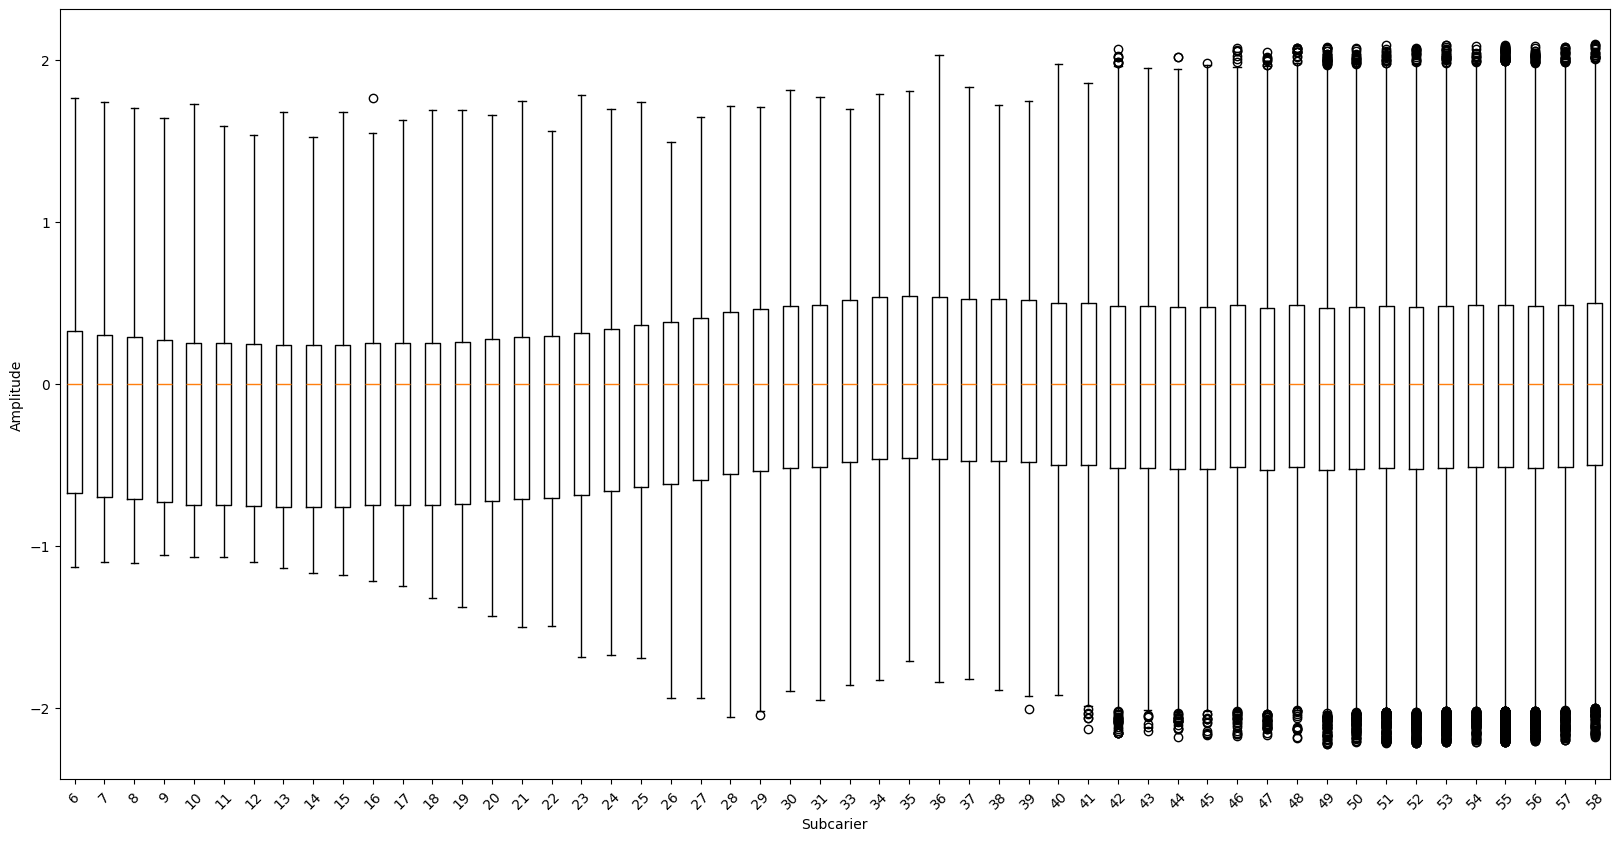

In [22]:
final_dd_df_without_label = final_dd_df.drop(columns=['label'])
plot_boxplots(final_dd_df_without_label,'Boxplot Before Normalization Amplituo Data')

C:\Users\Hp\AppData\Local\Temp\ipykernel_17240\2851536282.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_data, labels=df.columns)


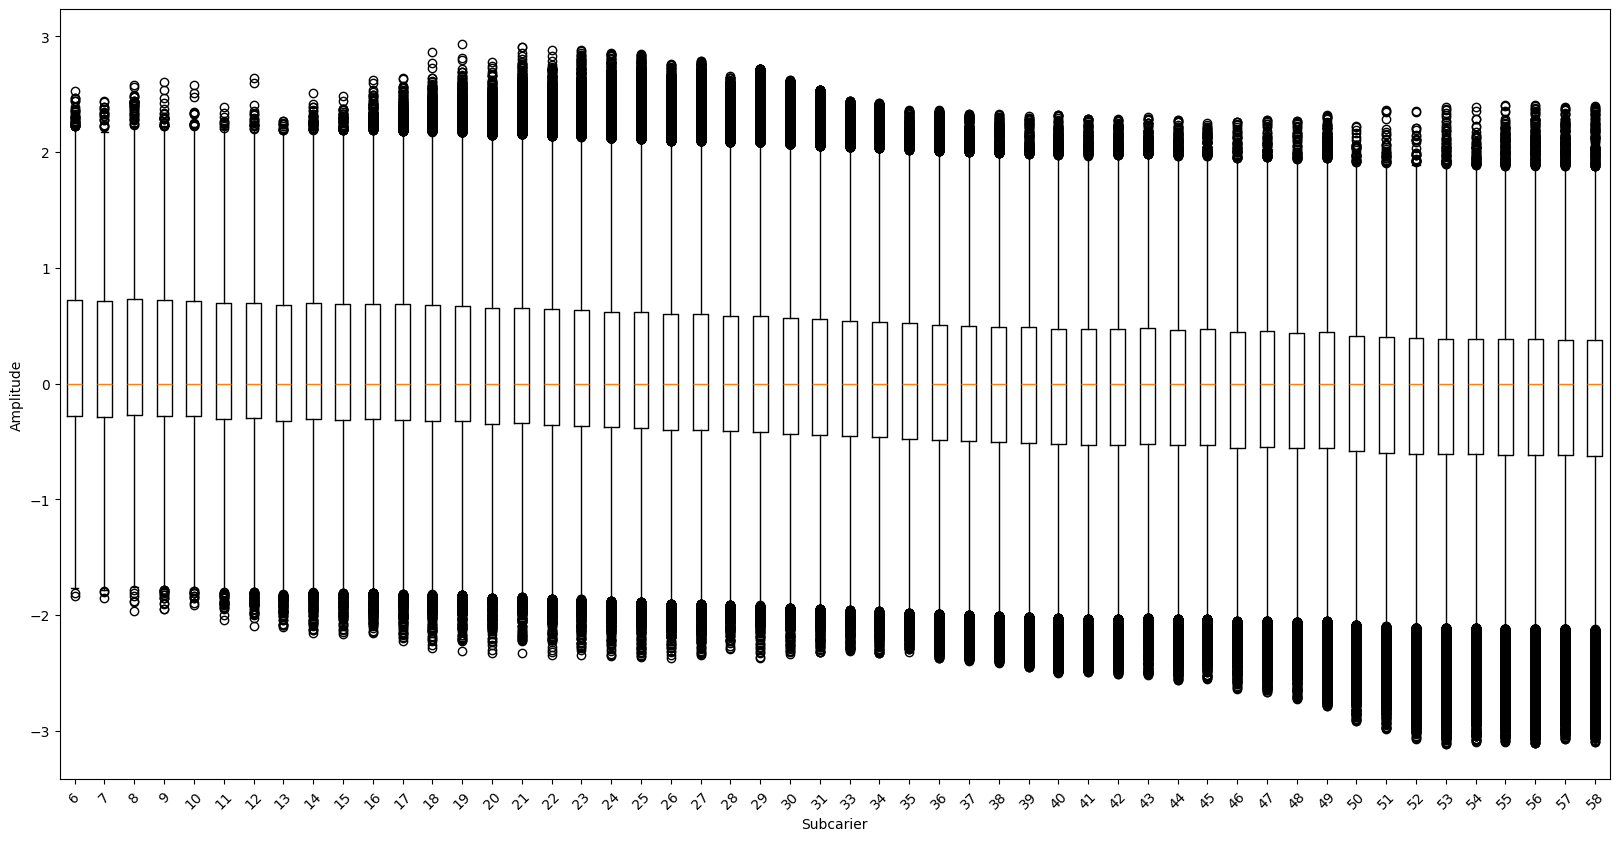

In [23]:
final_jl_df_without_label = final_jl_df.drop(columns=['label'])
plot_boxplots(final_jl_df_without_label,'Boxplot Before Normalization Amplituo Data')

C:\Users\Hp\AppData\Local\Temp\ipykernel_17240\2851536282.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_data, labels=df.columns)


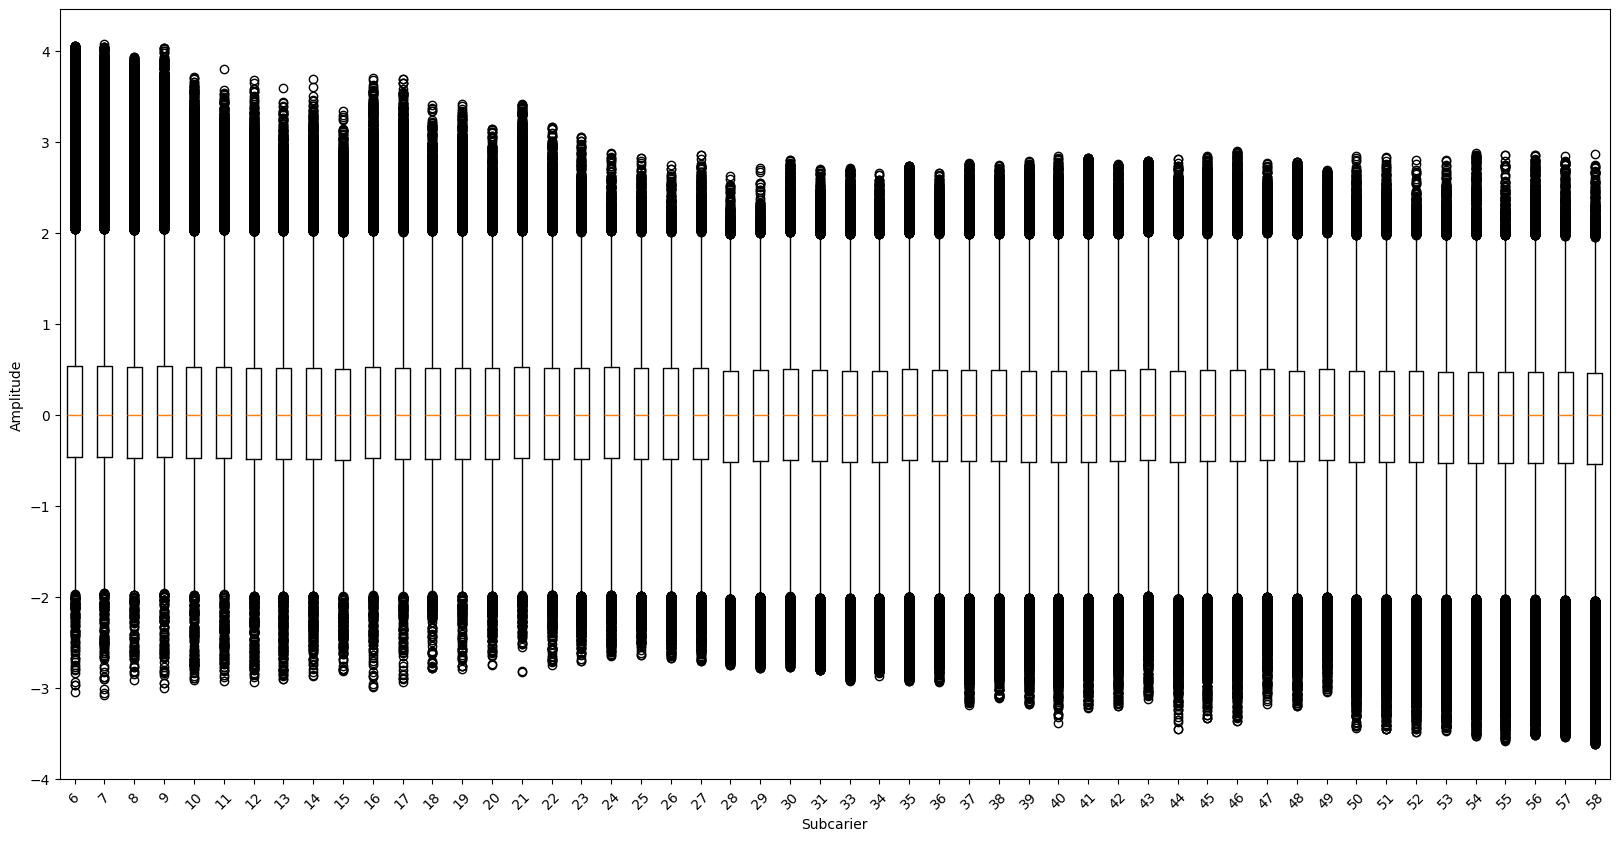

In [24]:
final_bd_df_without_label = final_bd_df.drop(columns=['label'])
plot_boxplots(final_bd_df_without_label,'Boxplot Before Normalization Amplituo Data')

In [25]:
print("dd Data after removing outliers and applying RobustScaler:")
final_dd_df

dd Data after removing outliers and applying RobustScaler:


,6,7,8,9,10,11,12,13,14,15,...,50,51,52,53,54,55,56,57,58,label
9,-1.049629,-1.019900,-0.908426,-0.880727,-0.872393,-0.842043,-0.859667,-0.808124,-0.789602,-0.715562,...,1.100791,1.377008,1.534712,1.631292,1.681197,1.311178,1.992968,1.358410,1.383416,0
10,-1.042861,-1.015701,-0.911902,-0.881635,-0.874478,-0.918720,-0.868047,-0.848060,-0.811520,-0.791526,...,-0.305850,-0.210831,-0.014583,0.146664,0.062271,-0.464478,0.073709,-0.105687,-0.026210,0
11,-1.069242,-1.005886,-0.911446,-0.882046,-0.887222,-0.985780,-0.861392,-0.873283,-0.832058,-0.879569,...,-1.242224,-1.310563,-1.132845,-1.018858,-1.186255,-1.676385,-1.056334,-1.233276,-1.178847,0
12,-1.073765,-0.995720,-0.898917,-0.907353,-0.896390,-0.991954,-0.860576,-0.867636,-0.842841,-0.877899,...,-1.386403,-1.457877,-1.312536,-1.156102,-1.217126,-1.533794,-1.178873,-1.284725,-1.174104,0
13,-1.066748,-0.971948,-0.910173,-0.913837,-0.915324,-0.949833,-0.841009,-0.821293,-0.830345,-0.863811,...,-0.808321,-0.778417,-0.759243,-0.551327,-0.623226,-0.862817,-0.532296,-0.825278,-0.580985,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68555,0.390742,0.356140,0.391892,0.396476,0.294445,0.267132,0.274190,0.247639,0.304827,0.230071,...,1.431670,1.258906,1.204914,1.104891,1.257472,1.219157,1.369095,1.045571,1.315057,0
68556,0.406895,0.362638,0.418669,0.440941,0.305252,0.262275,0.276096,0.270045,0.314295,0.213994,...,1.588813,1.288242,1.195776,1.260193,1.382338,1.544844,1.478231,1.057601,1.449911,0
68557,0.403920,0.358665,0.411659,0.442208,0.291895,0.243737,0.264665,0.271467,0.303889,0.201692,...,1.578912,1.236856,1.126451,1.276959,1.373588,1.560977,1.402277,1.018425,1.435744,0
68558,0.369449,0.334889,0.352040,0.374939,0.238583,0.201876,0.232169,0.240825,0.261363,0.192707,...,1.313019,1.068849,0.977741,1.062740,1.154561,1.115785,1.052475,0.908053,1.193619,0


In [26]:
print("JL Data after removing outliers and applying RobustScaler:")
final_jl_df

JL Data after removing outliers and applying RobustScaler:


,6,7,8,9,10,11,12,13,14,15,...,50,51,52,53,54,55,56,57,58,label
1,-0.920963,-0.470516,-0.839190,-0.741131,-0.656323,-0.761084,-0.983199,-0.750051,-0.843390,-0.842654,...,-1.255185,-0.759837,-1.543262,-1.406286,-1.668832,-1.859968,-2.250569,-2.232861,-2.597734,1
4,-0.471492,-0.425330,-0.656436,-0.832059,-0.350327,-0.557167,-0.498641,-0.664141,-0.583091,-0.554524,...,-1.830149,-1.587091,-1.773398,-2.165937,-1.820884,-2.223863,-2.144824,-2.584591,-2.491699,1
10,0.596395,0.830498,0.958646,0.771030,0.884586,1.103917,1.138008,1.025195,0.968152,1.074807,...,-1.755282,-0.541472,-1.099471,-1.183609,-1.054996,-2.384288,-0.991250,-0.922345,-0.971779,1
11,0.623732,1.037062,1.077328,0.905945,1.019057,1.146958,1.311477,1.279826,1.335879,1.340784,...,-2.057321,-1.249148,-2.325292,-2.096519,-2.399946,-2.794745,-2.173525,-2.008581,-1.857792,1
17,0.409569,0.414734,0.599251,0.656616,0.739075,0.789616,0.749567,0.861753,0.893627,0.951802,...,-2.781546,-2.475236,-1.802630,-1.759066,-1.810577,-2.001497,-2.121026,-1.625907,-1.201777,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69774,1.303393,1.294441,1.240073,1.235130,1.216400,1.232903,1.206457,1.146137,1.115498,1.029287,...,-0.607462,-0.773207,-0.592006,-0.726863,-0.567688,-0.848331,-0.698839,-0.912119,-0.848678,1
69775,1.079275,1.104894,1.066963,1.047264,0.986727,1.024322,1.013855,0.974499,0.919824,0.850368,...,-0.665106,-0.921000,-0.628252,-0.720852,-0.592901,-0.820863,-0.629179,-0.812887,-0.825209,1
69776,0.934413,1.009175,0.987354,0.974989,0.882734,0.913979,0.942284,0.909077,0.876012,0.821141,...,-0.539666,-0.769292,-0.460496,-0.576492,-0.532551,-0.622890,-0.459582,-0.545448,-0.673194,1
69777,0.941975,1.078076,1.067359,1.097258,0.996799,0.972572,1.075863,1.017450,1.077598,1.029609,...,-0.144598,-0.166942,0.007190,-0.236109,-0.355826,-0.190664,-0.167074,-0.064652,-0.341407,1


In [27]:
print("BD Data after removing outliers and applying RobustScaler:")
final_bd_df

BD Data after removing outliers and applying RobustScaler:


,6,7,8,9,10,11,12,13,14,15,...,50,51,52,53,54,55,56,57,58,label
9,0.582200,0.653840,0.756620,0.782651,0.776811,0.690293,0.883246,0.692638,0.880926,0.736659,...,1.298303,1.213754,0.753244,1.120568,1.455132,0.915782,1.332467,1.433471,1.086422,2
10,0.084460,0.138075,0.043393,0.194046,0.131908,0.238511,0.148185,0.238787,0.074565,0.186047,...,-0.026864,-0.027030,-0.547703,-0.240118,-0.063013,-0.291392,-0.260671,0.145784,-0.199770,2
11,-0.280312,-0.285692,-0.296732,-0.140105,-0.245704,-0.110235,-0.123172,-0.102292,-0.186932,-0.166098,...,-0.910604,-0.941724,-1.207364,-1.235299,-1.121273,-1.033713,-1.126044,-0.898587,-0.959638,2
12,-0.250941,-0.196465,-0.227764,0.051625,-0.239881,-0.012251,0.065848,0.043012,-0.049839,-0.090647,...,-0.793329,-0.906431,-1.008854,-1.155641,-1.086116,-0.948065,-0.916826,-1.061379,-0.707526,2
13,0.254283,0.026600,0.266169,0.411040,0.208270,0.346070,0.546583,0.211554,0.481932,0.242203,...,-0.291004,-0.319157,-0.368114,-0.426603,-0.331532,-0.296494,-0.155481,-0.366704,-0.143533,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78536,0.756556,1.959340,0.738092,1.073318,1.709969,0.611805,0.571185,0.530049,0.281949,0.416136,...,0.014927,-0.787967,0.942203,-0.551519,0.496647,-1.266822,1.922604,-0.877161,1.313757,2
78537,0.360069,1.371973,0.709914,1.153122,1.143810,0.650963,0.613696,0.403696,0.211979,0.292563,...,0.251681,-0.680583,0.793491,-0.665660,0.634248,-1.165900,1.250413,-1.106627,0.915598,2
78538,0.691823,1.379019,0.762520,1.271562,1.042024,0.741612,0.707600,0.377194,0.254580,0.301133,...,0.408502,-0.332369,0.604801,-0.408749,0.675365,-0.917606,1.868156,-0.337745,0.666115,2
78539,0.227784,0.998801,0.679195,1.123116,0.644796,0.467123,0.700123,0.398539,0.273200,0.221274,...,-1.446167,-1.509787,-1.438717,-2.215820,-1.473434,-2.253477,-0.655523,-1.862304,-1.850105,2


In [28]:
print(len(final_dd_df))
print(len(final_jl_df))
print(len(final_bd_df))

print('Total = ',len(final_dd_df)+len(final_jl_df)+len(final_bd_df))

64878
59093
53409
Total =  177380


In [29]:
merged_df = pd.concat([final_dd_df,
                       final_jl_df,
                       final_bd_df
                       ], axis=0)
merged_df

,6,7,8,9,10,11,12,13,14,15,...,50,51,52,53,54,55,56,57,58,label
9,-1.049629,-1.019900,-0.908426,-0.880727,-0.872393,-0.842043,-0.859667,-0.808124,-0.789602,-0.715562,...,1.100791,1.377008,1.534712,1.631292,1.681197,1.311178,1.992968,1.358410,1.383416,0
10,-1.042861,-1.015701,-0.911902,-0.881635,-0.874478,-0.918720,-0.868047,-0.848060,-0.811520,-0.791526,...,-0.305850,-0.210831,-0.014583,0.146664,0.062271,-0.464478,0.073709,-0.105687,-0.026210,0
11,-1.069242,-1.005886,-0.911446,-0.882046,-0.887222,-0.985780,-0.861392,-0.873283,-0.832058,-0.879569,...,-1.242224,-1.310563,-1.132845,-1.018858,-1.186255,-1.676385,-1.056334,-1.233276,-1.178847,0
12,-1.073765,-0.995720,-0.898917,-0.907353,-0.896390,-0.991954,-0.860576,-0.867636,-0.842841,-0.877899,...,-1.386403,-1.457877,-1.312536,-1.156102,-1.217126,-1.533794,-1.178873,-1.284725,-1.174104,0
13,-1.066748,-0.971948,-0.910173,-0.913837,-0.915324,-0.949833,-0.841009,-0.821293,-0.830345,-0.863811,...,-0.808321,-0.778417,-0.759243,-0.551327,-0.623226,-0.862817,-0.532296,-0.825278,-0.580985,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78536,0.756556,1.959340,0.738092,1.073318,1.709969,0.611805,0.571185,0.530049,0.281949,0.416136,...,0.014927,-0.787967,0.942203,-0.551519,0.496647,-1.266822,1.922604,-0.877161,1.313757,2
78537,0.360069,1.371973,0.709914,1.153122,1.143810,0.650963,0.613696,0.403696,0.211979,0.292563,...,0.251681,-0.680583,0.793491,-0.665660,0.634248,-1.165900,1.250413,-1.106627,0.915598,2
78538,0.691823,1.379019,0.762520,1.271562,1.042024,0.741612,0.707600,0.377194,0.254580,0.301133,...,0.408502,-0.332369,0.604801,-0.408749,0.675365,-0.917606,1.868156,-0.337745,0.666115,2
78539,0.227784,0.998801,0.679195,1.123116,0.644796,0.467123,0.700123,0.398539,0.273200,0.221274,...,-1.446167,-1.509787,-1.438717,-2.215820,-1.473434,-2.253477,-0.655523,-1.862304,-1.850105,2


In [30]:
threshold = 0.9  # 90% nilai 0

# Hitung persentase nol di setiap kolom
zero_ratio = (merged_df == 0).sum() / len(merged_df)

# Cari kolom yang lebih dari threshold
columns_to_drop = zero_ratio[zero_ratio > threshold].index.tolist()

print("Kolom yang mostly nol (>90%):")
print(columns_to_drop)


Kolom yang mostly nol (>90%):
[]


In [31]:
merged_df.describe()

,6,7,8,9,10,11,12,13,14,15,...,49,50,51,52,53,54,55,56,57,58
count,177380.000000,177380.000000,177380.000000,177380.000000,177380.000000,177380.000000,177380.000000,177380.000000,177380.000000,177380.000000,...,177360.000000,177342.000000,177342.000000,177329.000000,177319.000000,177313.000000,177312.000000,177308.000000,177306.000000,177306.000000
mean,0.064895,0.051506,0.049197,0.045147,0.025816,0.018169,0.013382,0.004095,0.010779,0.001313,...,-0.053345,-0.078746,-0.088167,-0.100274,-0.104136,-0.100614,-0.112806,-0.109199,-0.110912,-0.109920
std,0.775017,0.759741,0.756620,0.753765,0.732025,0.725331,0.730702,0.722220,0.737842,0.725834,...,0.788649,0.803778,0.813825,0.822655,0.836798,0.830982,0.847416,0.848648,0.848031,0.842792
min,-3.044856,-3.082913,-2.919416,-2.997451,-2.913124,-2.927188,-2.940527,-2.905384,-2.874114,-2.815558,...,-3.050891,-3.438950,-3.457148,-3.490309,-3.474290,-3.528207,-3.580788,-3.520453,-3.538947,-3.621134
25%,-0.484489,-0.503231,-0.509075,-0.519600,-0.532660,-0.541618,-0.550765,-0.556623,-0.558817,-0.565849,...,-0.526214,-0.537932,-0.542340,-0.544661,-0.545755,-0.542979,-0.547315,-0.546907,-0.546510,-0.543974
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.413472,0.392625,0.376771,0.365384,0.348520,0.344700,0.337643,0.340992,0.330671,0.335902,...,0.470318,0.454328,0.449488,0.444814,0.442507,0.444743,0.441804,0.441134,0.438686,0.440083
max,4.047886,4.071709,3.927549,4.032855,3.709487,3.804812,3.681190,3.595202,3.695305,3.336280,...,2.693345,2.842243,2.827492,2.801165,2.797985,2.871786,2.853353,2.853244,2.841744,2.864759


## Split Data

In [32]:
# Set seed for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [33]:
from sklearn.model_selection import train_test_split

# Asumsikan merged_df sudah didefinisikan sebelumnya
X = merged_df.iloc[:, :-1]
y = merged_df.iloc[:, -1]
# # Gabungkan menjadi satu dataframe
data = X.copy()
data['label'] = y
# # Drop NaN di seluruh data
data = data.dropna()

# # Pisahkan lagi
X = data.drop(columns=['label'])
y = data['label']
# Baris-baris di atas adalah persiapan data Anda, biarkan seperti itu.
# Kita akan fokus pada bagian setelah X dan y siap.

# Tahap 1: Pisahkan data menjadi data latih (70%) dan data sementara (30%)
# Data sementara ini akan dibagi lagi menjadi validasi dan uji.
# Gunakan stratify=y jika Anda ingin menjaga proporsi kelas (berguna untuk klasifikasi)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,  # 30% untuk data sementara (validasi + uji)
    random_state=seed,
    shuffle=True,
    stratify=y # Tambahkan jika y adalah target klasifikasi dan Anda ingin stratifikasi
)

# Tahap 2: Pisahkan data sementara (30% dari total) menjadi data validasi dan data uji.
# Kita ingin validasi 20% dari total dan uji 10% dari total.
# Dari data sementara (30%), kita ambil 1/3 untuk uji (0.30 * 1/3 = 0.10 atau 10% dari total).
# Sisanya (2/3 dari data sementara) akan menjadi data validasi (0.30 * 2/3 = 0.20 atau 20% dari total).
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.3333,  # Sekitar 1/3 dari X_temp untuk data uji (menghasilkan 10% dari total data)
    random_state=seed,
    shuffle=True,
    stratify=y_temp # Tambahkan jika y_temp adalah target klasifikasi dan Anda ingin stratifikasi
)

# Sekarang Anda memiliki:
# X_train, y_train (70% dari data asli)
# X_val, y_val (20% dari data asli, untuk validasi)
# X_test, y_test (10% dari data asli, untuk pengujian akhir)

print(f"Ukuran X_train: {X_train.shape}, Ukuran y_train: {y_train.shape}")
print(f"Ukuran X_val: {X_val.shape}, Ukuran y_val: {y_val.shape}")
print(f"Ukuran X_test: {X_test.shape}, Ukuran y_test: {y_test.shape}")

Ukuran X_train: (124114, 52), Ukuran y_train: (124114,)
Ukuran X_val: (35463, 52), Ukuran y_val: (35463,)
Ukuran X_test: (17729, 52), Ukuran y_test: (17729,)


In [34]:
# Hitung jumlah sampel di setiap kelas pada y_train (sebelum SMOTE)
unique_classes_before, class_counts_before = np.unique(y_train, return_counts=True)

# Tampilkan jumlah sampel di setiap kelas sebelum SMOTE
print("Jumlah sampel di setiap kelas SEBELUM SMOTE:")
for cls, count in zip(unique_classes_before, class_counts_before):
    print(f"Kelas {cls}: {count} sampel")

Jumlah sampel di setiap kelas SEBELUM SMOTE:
Kelas 0: 45380 sampel
Kelas 1: 41365 sampel
Kelas 2: 37369 sampel


In [35]:
from imblearn.over_sampling import SMOTE


# Terapkan SMOTE
smote = SMOTE(random_state=seed)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
# X_test_smote, y_test_smote = smote.fit_resample(X_test, y_test)

print("Shape data setelah SMOTE:")
print(f"X_train_smote: {X_train_smote.shape}, y_train_smote: {y_train_smote.shape}")
# print(f"X_test_smote: {X_test_smote.shape}, y_test_smote: {y_test_smote.shape}")

Shape data setelah SMOTE:
X_train_smote: (136140, 52), y_train_smote: (136140,)


In [36]:
# Hitung jumlah sampel di setiap kelas
unique_classes, class_counts = np.unique(y_train_smote, return_counts=True)

# Tampilkan jumlah sampel di setiap kelas
for cls, count in zip(unique_classes, class_counts):
    print(f"Kelas {cls}: {count} sampel")


Kelas 0: 45380 sampel
Kelas 1: 45380 sampel
Kelas 2: 45380 sampel


In [37]:
class_counts

array([45380, 45380, 45380])

In [38]:
unique_classes


array(['0', '1', '2'], dtype=object)

In [39]:
dd_counts_smote = {str(0): class_counts[0]}
jl_counts_smote = {str(1): class_counts[1]}
bd_counts_smote = {str(2): class_counts[2]}


In [40]:
dd_counts_smote

{'0': np.int64(45380)}

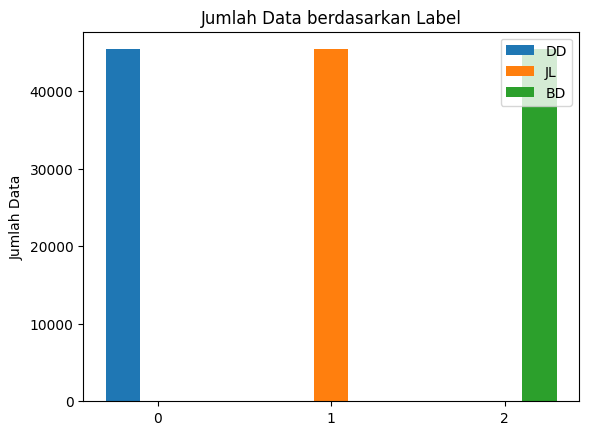

In [41]:
plot_bar_chart(dd_counts_smote, jl_counts_smote, bd_counts_smote)

In [42]:
print(X_train_smote.shape)
print(y_train_smote.shape)


(136140, 52)
(136140,)


# Trainng With Filtration and Normalization (Robust Scaler) Balancing (SMOTE)



In [43]:
import tensorflow as tf

class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],), initializer="zeros", trainable=True)
        self.u = self.add_weight(name="att_u", shape=(input_shape[-1],), initializer="glorot_uniform", trainable=True)

    def call(self, inputs):
        v = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        vu = tf.tensordot(v, self.u, axes=1)
        alphas = tf.nn.softmax(vu)
        output = tf.reduce_sum(inputs * tf.expand_dims(alphas, -1), 1)
        return output



In [44]:
def get_MLP_model(input_dim, learning_rate,num_classes, lstm_units, dense_units):
    InputLayer = tf.keras.layers.InputLayer
    Dense = tf.keras.layers.Dense
    LSTM = tf.keras.layers.LSTM
    Dropout = tf.keras.layers.Dropout

    model = tf.keras.Sequential(
      [
          InputLayer(input_shape=input_dim),
          LSTM(lstm_units, return_sequences=True),
          Attention(),
        #   Dropout(dropout_rate),
          Dense(dense_units, activation=tf.nn.relu),
        #   Dropout(dropout_rate),
          Dense(num_classes, activation=tf.nn.softmax)
      ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [45]:
# def get_MLP_model(input_dim, learning_rate, num_classes):
#     model = tf.keras.Sequential([
#         tf.keras.layers.Input(shape=input_dim),
#         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
#         tf.keras.layers.Dropout(0.3),
#         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
#         tf.keras.layers.Dropout(0.3),
#         tf.keras.layers.Dense(64, activation='relu'),
#         tf.keras.layers.Dense(32, activation='relu'),
#         tf.keras.layers.Dense(num_classes, activation='softmax')
#     ])
    
#     optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
#     model.compile(
#         loss='sparse_categorical_crossentropy', 
#         optimizer=optimizer, 
#         metrics=['accuracy']
#     )
    
#     return model


In [46]:
# --- Persiapan Data untuk Model ---
# Data Latih (hasil SMOTE)
flat_data = np.array(X_train_smote) # Ini sudah benar jika X_train_smote adalah hasil SMOTE dari training split
flat_data = flat_data.reshape((X_train_smote.shape[0], 1, flat_data.shape[1]))
label_in = np.array(y_train_smote)
label_in = label_in.astype(np.float64)

# Menambah Dimensi Baru: Penambahan dimensi baru (dengan nilai 1) sering kali diperlukan untuk menyesuaikan 
# data ke dalam bentuk yang diharapkan oleh model tertentu. Misalnya, model LSTM atau CNN sering kali 
# memerlukan input dengan tiga dimensi (batch size, number of channels, number of features/timesteps).

# Keseragaman Bentuk Data: Mengubah bentuk data menjadi konsisten dan sesuai dengan persyaratan 
# input dari model yang akan digunakan. Ini penting untuk memastikan bahwa data dapat diproses 
# dengan benar oleh lapisan-lapisan dalam model.

In [47]:
# Creating checkpoint callback for loading best weights
checkpoint_filepath = r'C:\Users\Hp\Documents\SKRIPSI !!!!!\TA\TA_saya\MLP_checkpoint\best_model.weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [48]:
# Creating checkpoint callback for loading best weights
checkpoint_filepath = r'C:\Users\Hp\Documents\SKRIPSI !!!!!\TA\TA_saya\MLP_checkpoint\best_model.weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [49]:
# Callback untuk early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

In [50]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=5, 
                              min_lr=0.0001)

In [51]:
tf.config.list_physical_devices('GPU')

[]

In [52]:
MLP_model_normalozation = get_MLP_model(flat_data[0].shape, 0.001, 3, 128, 8) # Num_classes=4, lstm_units=128, dense_units=8
MLP_model_normalozation.summary()

C:\Users\Hp\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 128)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,371 (431.14 KB)

 Trainable params: 110,371 (431.14 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# Data Validasi (ASLI, TIDAK DI-SMOTE)
# Anda perlu menyiapkan X_val_orig dan y_val_orig dari pembagian data awal
# Contoh:
X_val_reshaped = np.array(X_val).reshape((X_val.shape[0], 1, X_val.shape[1]))
y_val_feed = np.array(y_val).astype(np.float64)

In [54]:
MLP_Robust_History = MLP_model_normalozation.fit(
    flat_data,
    label_in,
    batch_size=128,
    epochs=100,
    # GANTI validation_split dengan validation_data
    # validation_split=0.2, # HINDARI INI JIKA flat_data SUDAH DI-SMOTE
    validation_data=(X_val_reshaped, y_val_feed), # GUNAKAN DATA VALIDASI ASLI YANG SUDAH DISIAPKAN
    shuffle=True,
    callbacks=[model_checkpoint_callback, early_stopping, reduce_lr] # Pastikan model_checkpoint_callback ada di list ini
)

Epoch 1/100
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6455 - loss: 0.7440 - val_accuracy: 0.8506 - val_loss: 0.3844 - learning_rate: 0.0010
Epoch 2/100
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8596 - loss: 0.3707 - val_accuracy: 0.8782 - val_loss: 0.3213 - learning_rate: 0.0010
Epoch 3/100
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8827 - loss: 0.3140 - val_accuracy: 0.8970 - val_loss: 0.2803 - learning_rate: 0.0010
Epoch 4/100
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8960 - loss: 0.2800 - val_accuracy: 0.9062 - val_loss: 0.2576 - learning_rate: 0.0010
Epoch 5/100
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9035 - loss: 0.2582 - val_accuracy: 0.9122 - val_loss: 0.2414 - learning_rate: 0.0010
Epoch 6/100
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9099 - loss: 0.2418 - val_accuracy: 0.9166 - val_loss: 0.2293 - learning_rate: 0.0010
Epoch 7/100
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9

In [55]:
%matplotlib inline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import itertools
import matplotlib.pyplot as plt

In [56]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [57]:
# Persiapan Data Uji (ASLI, TIDAK DI-SMOTE)
# test_data_normalization = np.array(X_test_smote) # GANTI INI
test_data_normalization = np.array(X_test) # Gunakan data uji ASLI
test_data_normalization = test_data_normalization.reshape((test_data_normalization.shape[0], 1, test_data_normalization.shape[1]))

# test_label_normalization = np.array(y_test_smote) # GANTI INI
test_label_normalization = np.array(y_test) # Gunakan label uji ASLI
test_label_normalization = test_label_normalization.astype(np.float64) 

In [58]:
train_data_normalization = np.array(X_train_smote)
train_data_normalization = train_data_normalization.reshape((train_data_normalization.shape[0], 1, train_data_normalization.shape[1]))

train_label_normalization = np.array(y_train_smote)
train_label_normalization = train_label_normalization.astype(np.float64)



17729/17729 - 25s - 1ms/step
Confusion matrix, without normalization
[[6375   26   81]
 [  51 5605  253]
 [ 101  245 4992]]
Per class:  [0.98349275 0.94855305 0.93518172]
              precision    recall  f1-score   support

          DD       0.98      0.98      0.98      6482
          JL       0.95      0.95      0.95      5909
          BD       0.94      0.94      0.94      5338

    accuracy                           0.96     17729
   macro avg       0.96      0.96      0.96     17729
weighted avg       0.96      0.96      0.96     17729



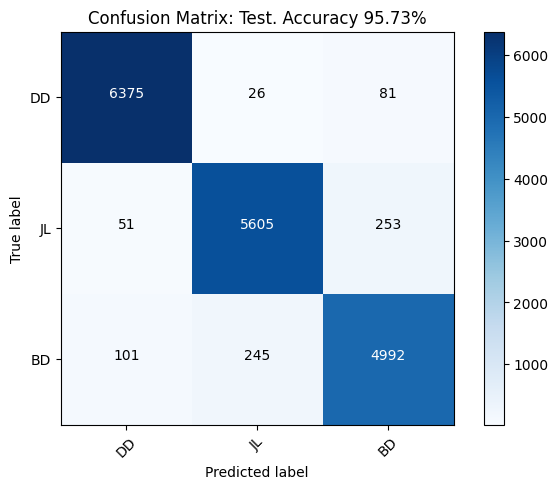

In [59]:
# Prediksi dan evaluasi menggunakan data uji asli
test_predictions_normalization = MLP_model_normalozation.predict(
    x=test_data_normalization, # Data uji asli yang sudah di-reshape
    batch_size=1, # Anda bisa sesuaikan batch_size untuk prediksi
    verbose=2
)
rounded_predictions_normalization = np.argmax(test_predictions_normalization, axis=-1)

cm_plot_labels = ['DD', 'JL', 'BD']
cm = confusion_matrix(y_true=test_label_normalization, y_pred=rounded_predictions_normalization)
accuracy = accuracy_score(test_label_normalization, rounded_predictions_normalization) * 100
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, 
                      # title=f'Confusion Matrix Test'
                      title=f'Confusion Matrix: Test. Accuracy {accuracy:.02f}%'
                      )
print("Per class: ", cm.diagonal()/cm.sum(axis=1))


# Mencetak classification report
report = classification_report(test_label_normalization, rounded_predictions_normalization, target_names=cm_plot_labels)
print(report)

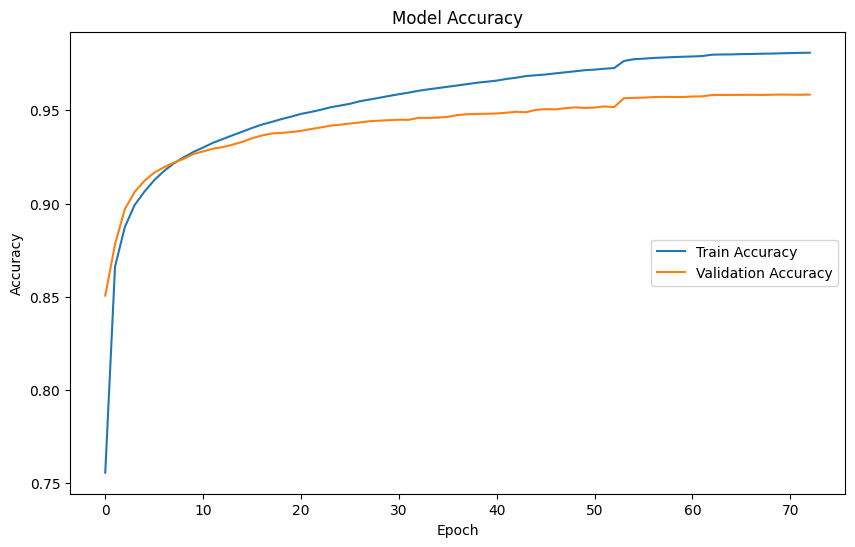

In [60]:
# Untuk plot history
train_accuracy = MLP_Robust_History.history['accuracy'] # Biasanya 'accuracy' bukan 'loss' untuk plot akurasi
val_accuracy = MLP_Robust_History.history['val_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy') # Ganti label 'test' menjadi 'validation'
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='center right') # Sesuaikan lokasi legenda jika perlu
plt.show() # Tambahkan plt.show() untuk menampilkan plot

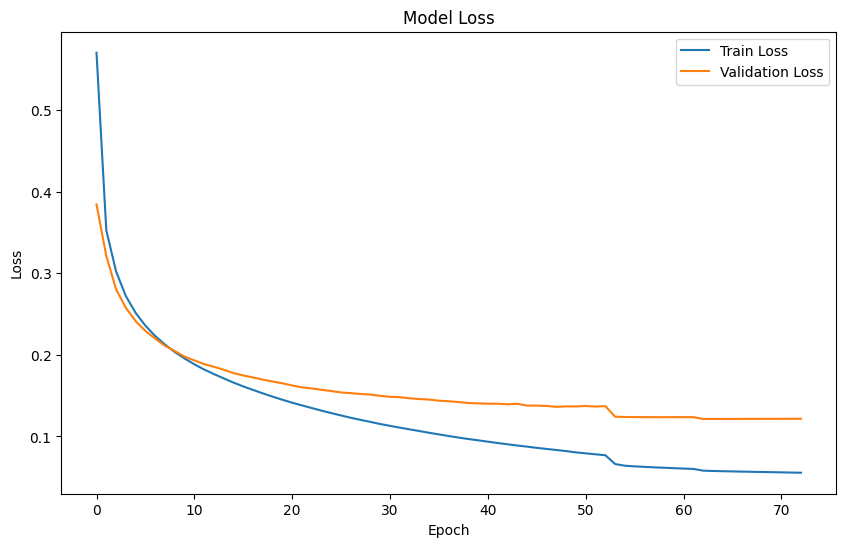

In [61]:
train_loss = MLP_Robust_History.history['loss']
val_loss = MLP_Robust_History.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss') # Ganti label 'test' menjadi 'validation'
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right') # Sesuaikan lokasi legenda jika perlu
plt.show() # Tambahkan plt.show() untuk menampilkan plot